**Drashti Sanghani**

**U01995615**

# **Project 3**

In [1]:
from google.colab import files
upload= files.upload()

Saving SN_d_tot_V2.0.csv to SN_d_tot_V2.0.csv
Saving SN_m_tot_V2.0.csv to SN_m_tot_V2.0.csv
Saving SN_y_tot_V2.0.csv to SN_y_tot_V2.0.csv


# **Importing Libraries**

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [123]:
daily_file = "SN_d_tot_V2.0.csv"
monthly_file = "SN_m_tot_V2.0.csv"
yearly_file = "SN_y_tot_V2.0.csv"

# **Daily Data**

In [124]:
# Assume the delimiter is a semicolon (';') as specified in the description
data = pd.read_csv(daily_file, header=None, delimiter=';')

# Assign column names according to the description
column_names = [
    'Year', 'Month', 'Day', 'Fractional_Year', 'Sunspots',
    'Deviation', 'no_of_observations', 'Indicator'
]

# Assign the column names to the dataframe
data.columns = column_names

# Convert numerical columns to appropriate datatypes
for col in ['Year', 'Month', 'Day', 'Fractional_Year', 'Sunspots', 'Deviation', 'no_of_observations']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Display the first few rows of the dataset
data.head()

,Year,Month,Day,Fractional_Year,Sunspots,Deviation,no_of_observations,Indicator
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


# **Understanding the data(Date)**

In [125]:
data.shape

(74630, 8)

In [126]:
data.columns

Index(['Year', 'Month', 'Day', 'Fractional_Year', 'Sunspots', 'Deviation',
       'no_of_observations', 'Indicator'],
      dtype='object')

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74630 entries, 0 to 74629
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                74630 non-null  int64  
 1   Month               74630 non-null  int64  
 2   Day                 74630 non-null  int64  
 3   Fractional_Year     74630 non-null  float64
 4   Sunspots            74630 non-null  int64  
 5   Deviation           74630 non-null  float64
 6   no_of_observations  74630 non-null  int64  
 7   Indicator           74630 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.6 MB


In [128]:
data.describe()

,Year,Month,Day,Fractional_Year,Sunspots,Deviation,no_of_observations,Indicator
count,74630.000000,74630.000000,74630.000000,74630.000000,74630.000000,74630.000000,74630.000000,74630.000000
mean,1919.665416,6.516522,15.729130,1920.164876,78.580142,6.905413,4.867279,0.998392
std,58.985539,3.449999,8.799916,58.985309,77.303259,4.792459,8.838895,0.040067
min,1818.000000,1.000000,1.000000,1818.001000,-1.000000,-1.000000,0.000000,0.000000
25%,1869.000000,4.000000,8.000000,1869.081750,15.000000,2.900000,1.000000,1.000000
50%,1920.000000,7.000000,16.000000,1920.166500,57.000000,6.500000,1.000000,1.000000
75%,1971.000000,10.000000,23.000000,1971.247250,123.000000,10.000000,1.000000,1.000000
max,2022.000000,12.000000,31.000000,2022.327000,528.000000,77.700000,69.000000,1.000000


In [129]:
data.isnull().sum()

,0
Year,0
Month,0
Day,0
Fractional_Year,0
Sunspots,0
Deviation,0
no_of_observations,0
Indicator,0


In [130]:
# Count rows with invalid Sunspot data (-1)
invalid_sunspots = data[data['Sunspots'] == -1].shape[0]
print(f"Number of rows with invalid Sunspot data (-1): {invalid_sunspots}")

# Filter out invalid Sunspot data
data_cleaned = data[data['Sunspots'] >= 0]

Number of rows with invalid Sunspot data (-1): 3247


**Histogram of Numeric Columns**

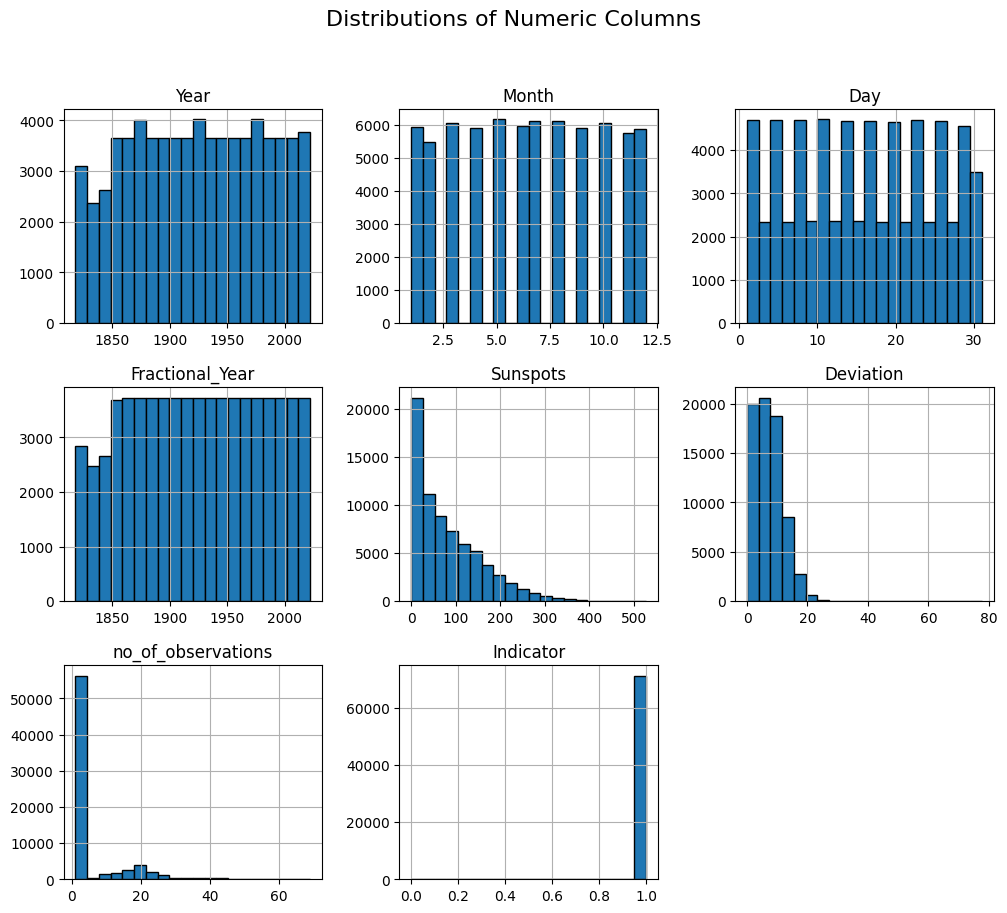

In [131]:
# Plot histograms for numeric columns
data_cleaned.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Distributions of Numeric Columns", fontsize=16)
plt.show()

**Boxplot to Identify Outliers**

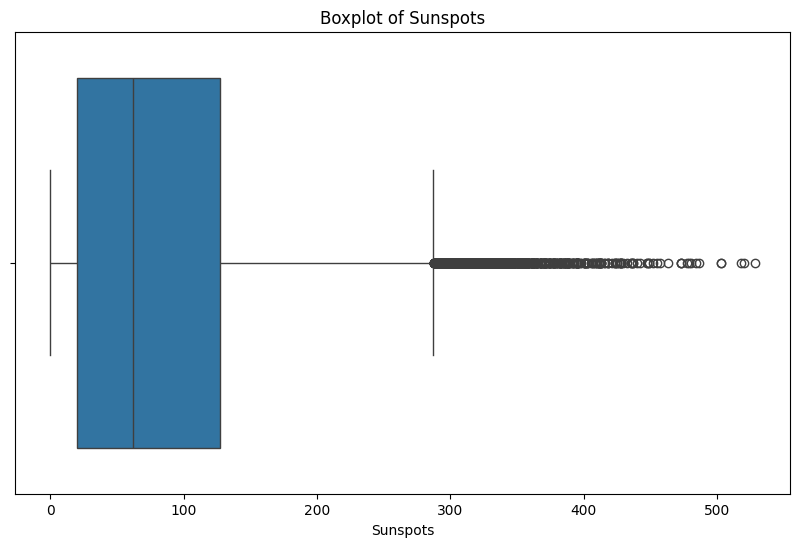

In [132]:
# Boxplot for Sunspots
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_cleaned['Sunspots'])
plt.title("Boxplot of Sunspots")
plt.show()

**Handle Outliers**

In [133]:
# Remove outliers based on a threshold
q1 = data_cleaned['Sunspots'].quantile(0.25)
q3 = data_cleaned['Sunspots'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter data within the bounds
data_no_outliers = data_cleaned[(data_cleaned['Sunspots'] >= lower_bound) & (data_cleaned['Sunspots'] <= upper_bound)]
print(f"Number of rows after removing outliers: {data_no_outliers.shape[0]}")

Number of rows after removing outliers: 70093


# **Data Visualization(Date)**

**Sunspot Time Series**

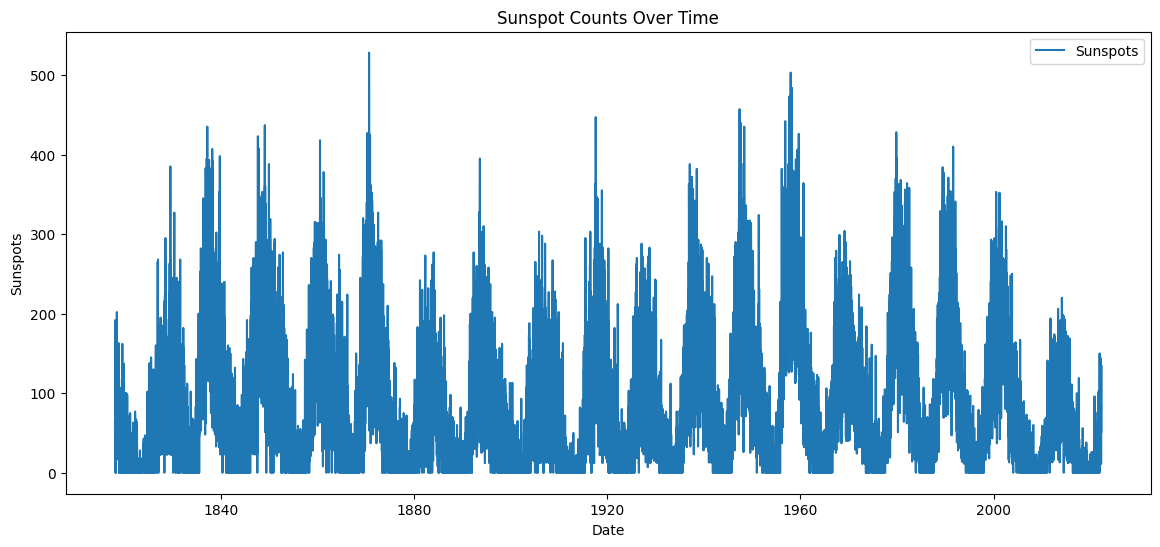

In [181]:
# Create a new column for the complete date
data_cleaned['Date'] = pd.to_datetime(data_cleaned[['Year', 'Month', 'Day']])

# Plot Sunspot values over time
plt.figure(figsize=(14, 6))
plt.plot(data_cleaned['Date'], data_cleaned['Sunspots'], label="Sunspots")
plt.title("Sunspot Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.legend()
plt.show()

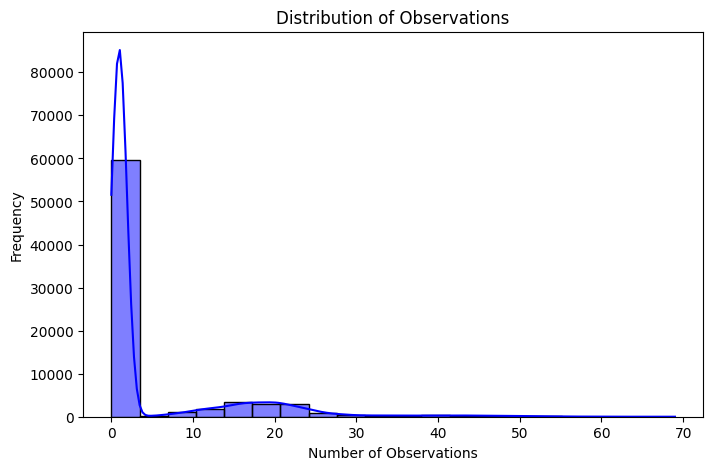

In [135]:
# Frequency of the number of observations
plt.figure(figsize=(8, 5))
sns.histplot(data['no_of_observations'], bins=20, kde=True, color="blue")
plt.title("Distribution of Observations")
plt.xlabel("Number of Observations")
plt.ylabel("Frequency")
plt.show()

**Extract Time-Related Features**


Observations by Weekday:
Weekday
Thursday     10662
Friday       10662
Saturday     10662
Sunday       10661
Monday       10661
Tuesday      10661
Wednesday    10661
Name: count, dtype: int64


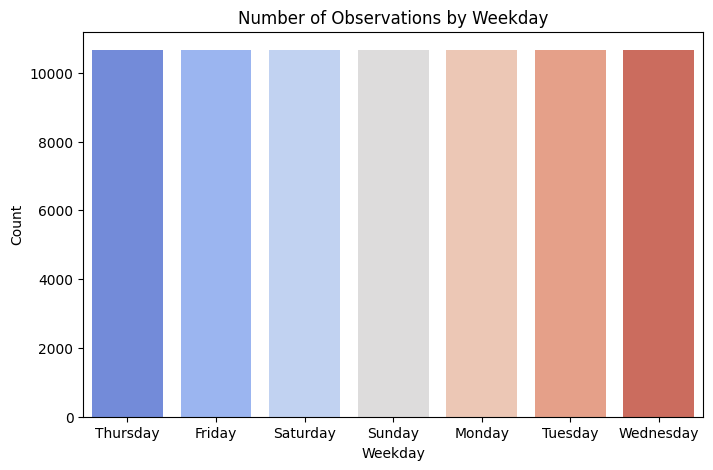

In [182]:
# Create new features for analysis
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data['Weekday'] = data['Date'].dt.day_name()
data['Quarter'] = data['Date'].dt.quarter

# Count occurrences by weekday
weekday_counts = data['Weekday'].value_counts()
print("\nObservations by Weekday:")
print(weekday_counts)

# Visualize weekday trends
plt.figure(figsize=(8, 5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="coolwarm")
plt.title("Number of Observations by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.show()

**Histogram of Sunspots**

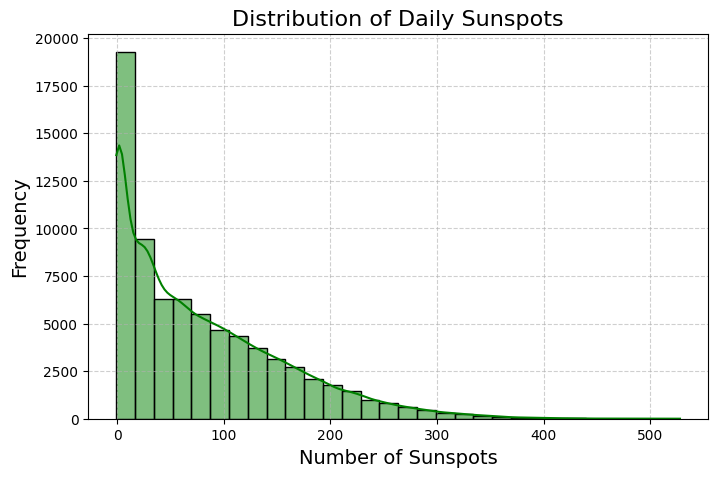

In [137]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Sunspots'], bins=30, kde=True, color='green')
plt.title('Distribution of Daily Sunspots', fontsize=16)
plt.xlabel('Number of Sunspots', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Monthly Average Sunspots**

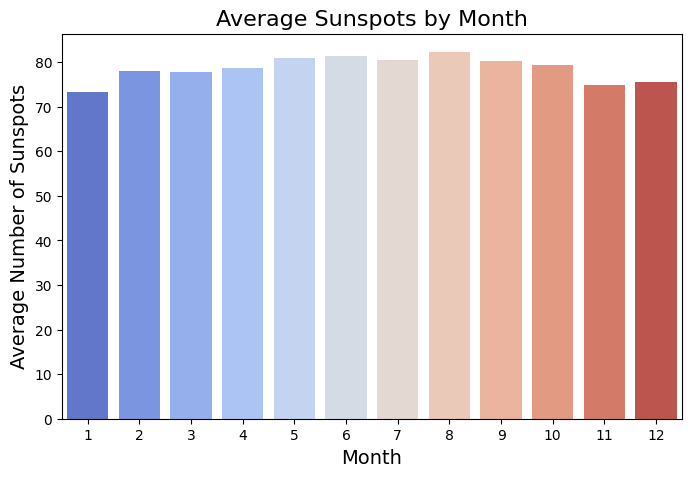

In [183]:
# Group by Month
monthly_avg = data.groupby('Month')['Sunspots'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='coolwarm')
plt.title('Average Sunspots by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Number of Sunspots', fontsize=14)
plt.show()

**Daily Sunspot Count with Rolling Average**

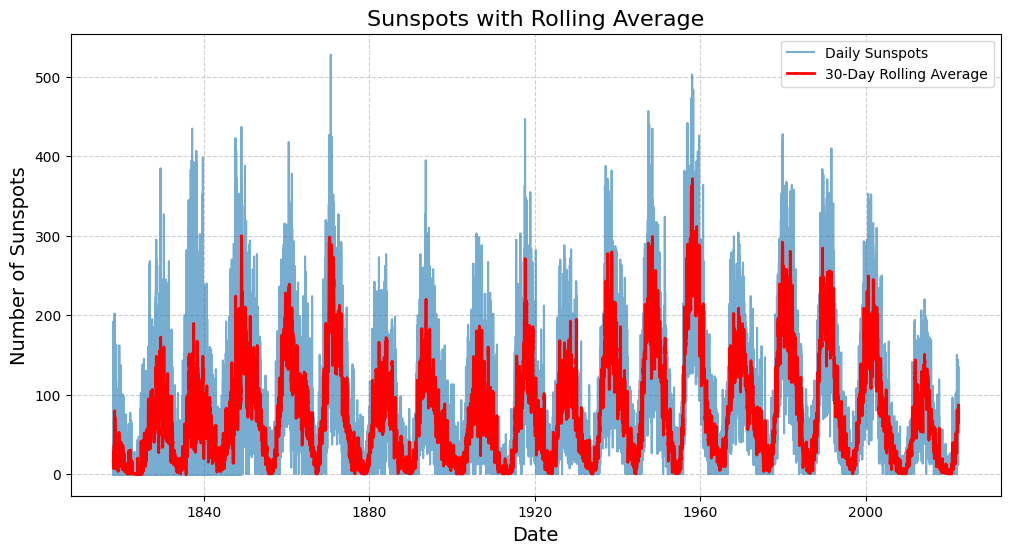

In [139]:
# Calculate rolling average
data['Sunspots_Rolling'] = data['Sunspots'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Sunspots'], label='Daily Sunspots', alpha=0.6)
plt.plot(data['Date'], data['Sunspots_Rolling'], label='30-Day Rolling Average', color='red', linewidth=2)
plt.title('Sunspots with Rolling Average', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Sunspots', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Correlation Matrix**

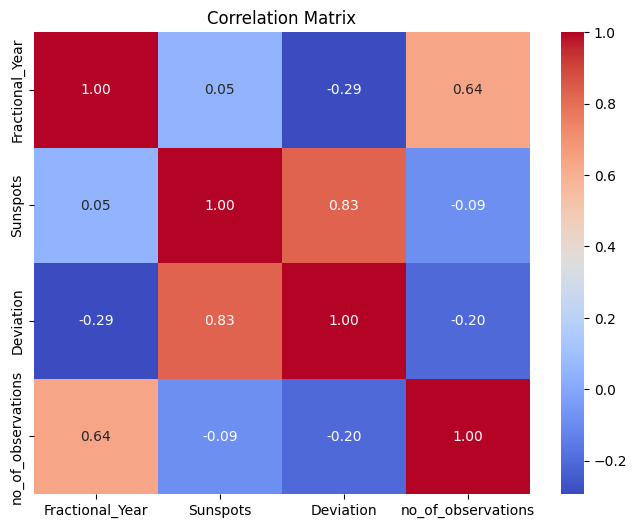

In [140]:
# Calculate correlations
correlation_matrix = data_cleaned[['Fractional_Year', 'Sunspots', 'Deviation', 'no_of_observations']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# **Monthly Data**

In [141]:
# Assume the delimiter is a semicolon (';') as specified in the description
data1 = pd.read_csv(monthly_file, header=None, delimiter=';')

# Assign column names according to the description
column_names = [
    'Year', 'Month', 'Fractional_Year', 'Mean_Sunspots',
    'Std_Deviation', 'no_ofobservations', 'Indicator'
]

# Assign the column names to the dataframe
data1.columns = column_names

# Convert numerical columns to appropriate datatypes
for col in ['Year', 'Month', 'Fractional_Year', 'Mean_Sunspots', 'Std_Deviation', 'no_ofobservations']:
    data1[col] = pd.to_numeric(data1[col], errors='coerce')

# Display the first few rows of the dataset
data1.head()

,Year,Month,Fractional_Year,Mean_Sunspots,Std_Deviation,no_ofobservations,Indicator
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


# **Understanding the data (Month)**

In [142]:
data1.shape

(3280, 7)

In [143]:
data1.describe()

,Year,Month,Fractional_Year,Mean_Sunspots,Std_Deviation,no_ofobservations,Indicator
count,3280.000000,3280.000000,3280.000000,3280.000000,3280.000000,3280.000000,3280.000000
mean,1885.167073,6.495122,1885.664664,81.594329,5.567896,110.492988,0.998780
std,78.916744,3.453518,78.916547,67.805438,5.220310,234.964151,0.034906
min,1749.000000,1.000000,1749.042000,0.000000,-1.000000,-1.000000,0.000000
25%,1817.000000,3.000000,1817.350250,23.900000,-1.000000,-1.000000,1.000000
50%,1885.000000,6.000000,1885.665000,66.850000,5.300000,30.000000,1.000000
75%,1953.250000,9.000000,1953.979000,122.400000,9.400000,31.000000,1.000000
max,2022.000000,12.000000,2022.286000,398.200000,23.500000,1587.000000,1.000000


In [144]:
data1.columns

Index(['Year', 'Month', 'Fractional_Year', 'Mean_Sunspots', 'Std_Deviation',
       'no_ofobservations', 'Indicator'],
      dtype='object')

In [145]:
data1.isnull().sum()

,0
Year,0
Month,0
Fractional_Year,0
Mean_Sunspots,0
Std_Deviation,0
no_ofobservations,0
Indicator,0


In [146]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3280 entries, 0 to 3279
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               3280 non-null   int64  
 1   Month              3280 non-null   int64  
 2   Fractional_Year    3280 non-null   float64
 3   Mean_Sunspots      3280 non-null   float64
 4   Std_Deviation      3280 non-null   float64
 5   no_ofobservations  3280 non-null   int64  
 6   Indicator          3280 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 179.5 KB


In [147]:
# Count rows with invalid Sunspot data (-1)
invalid_sunspots = data1[data1['Mean_Sunspots'] == -1].shape[0]
print(f"Number of rows with invalid Sunspot data (-1): {invalid_sunspots}")

# Filter out invalid Sunspot data
data_cleaned1 = data1[data1['Mean_Sunspots'] >= 0]

Number of rows with invalid Sunspot data (-1): 0


**Histograms for Numeric columns**

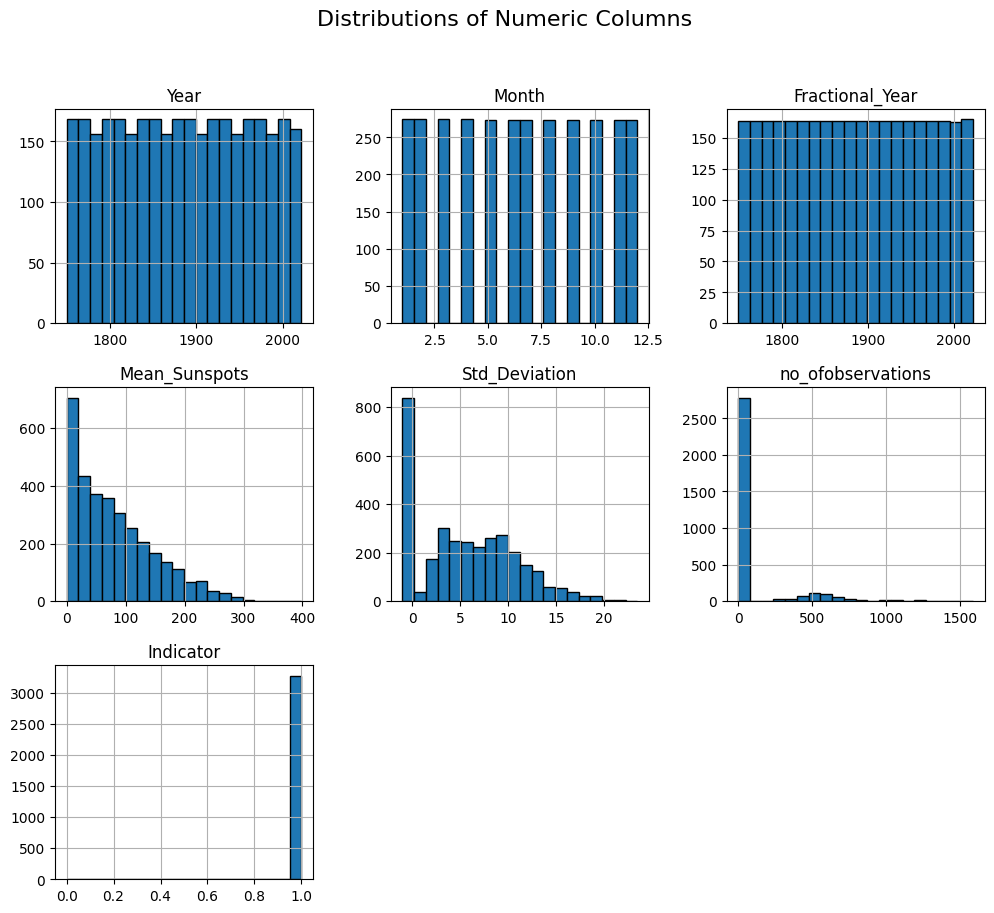

In [148]:
# Plot histograms for numeric columns
data_cleaned1.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Distributions of Numeric Columns", fontsize=16)
plt.show()

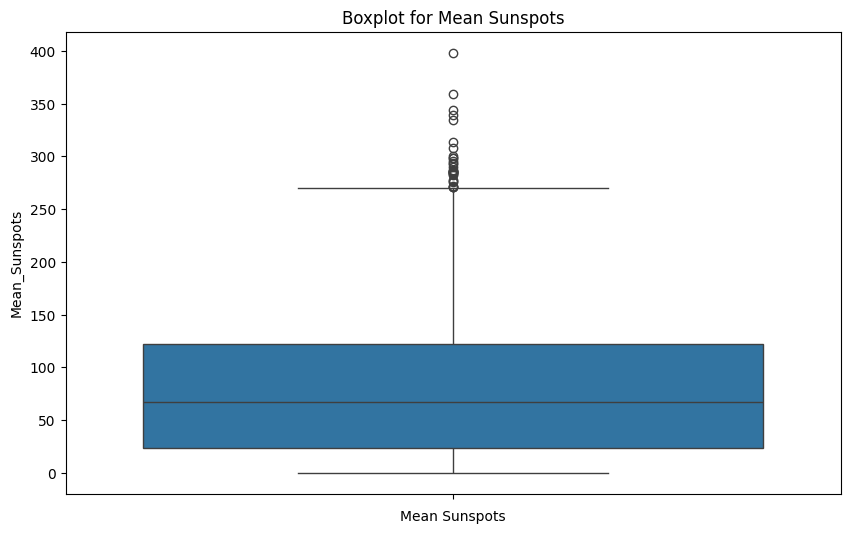

In [149]:
# Create a boxplot to visually check for outliers in 'Mean_Sunspots'
plt.figure(figsize=(10, 6))
sns.boxplot(data1['Mean_Sunspots'])
plt.title("Boxplot for Mean Sunspots")
plt.xlabel("Mean Sunspots")
plt.show()

In [150]:
# Remove outliers based on a threshold
q1 = data_cleaned1['Mean_Sunspots'].quantile(0.25)
q3 = data_cleaned1['Mean_Sunspots'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter data within the bounds
data_no_outliers = data_cleaned1[(data_cleaned1['Mean_Sunspots'] >= lower_bound) & (data_cleaned1['Mean_Sunspots'] <= upper_bound)]
print(f"Number of rows after removing outliers: {data_no_outliers.shape[0]}")

Number of rows after removing outliers: 3249


# **Data Visuaization (Month)**

**Line plot for the trend of Mean Sunspots over time**

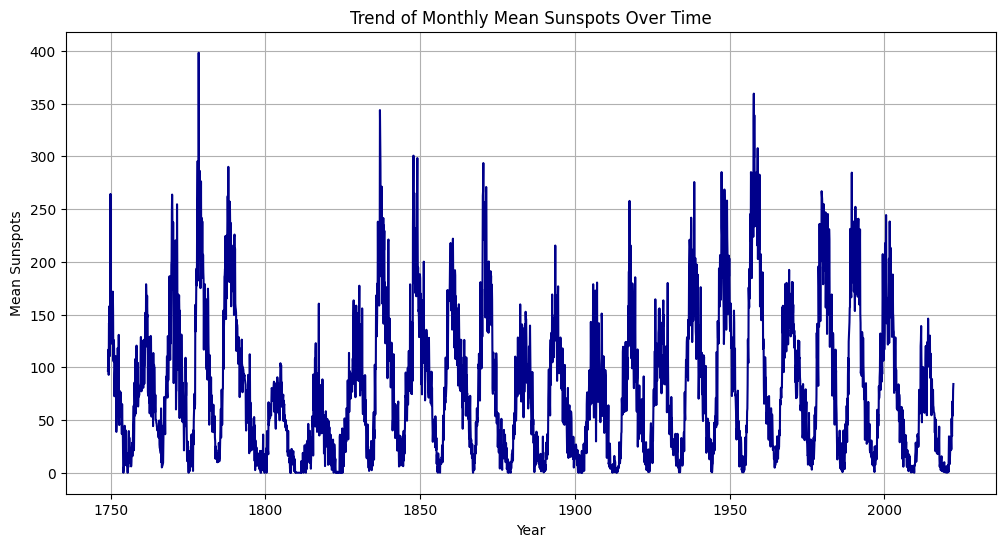

In [151]:
# Line plot for the trend of Mean Sunspots over time
plt.figure(figsize=(12, 6))
plt.plot(data1['Year'] + data1['Month'] / 12, data1['Mean_Sunspots'], color='darkblue')
plt.title('Trend of Monthly Mean Sunspots Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Sunspots')
plt.grid(True)
plt.show()

**Monthly Aggregations**

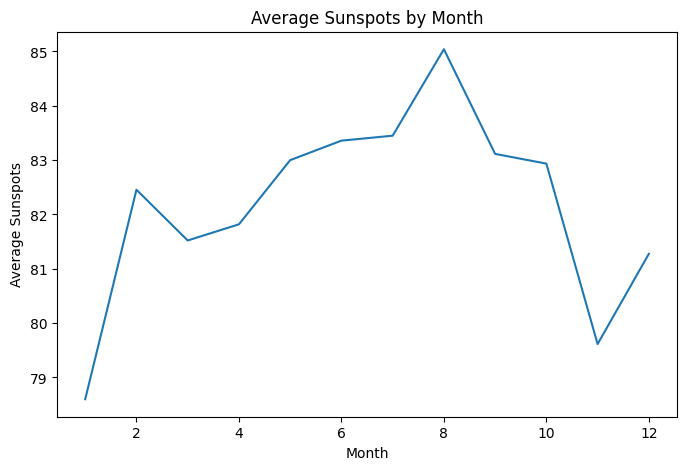

In [187]:
# Group by month to observe monthly trends
monthly_avg = data_cleaned.groupby('Month')['Sunspots'].mean()
plt.figure(figsize=(8, 5))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, palette="blue")
plt.title("Average Sunspots by Month")
plt.xlabel("Month")
plt.ylabel("Average Sunspots")
plt.show()

**Bar Plot: Mean Sunspots by Year**

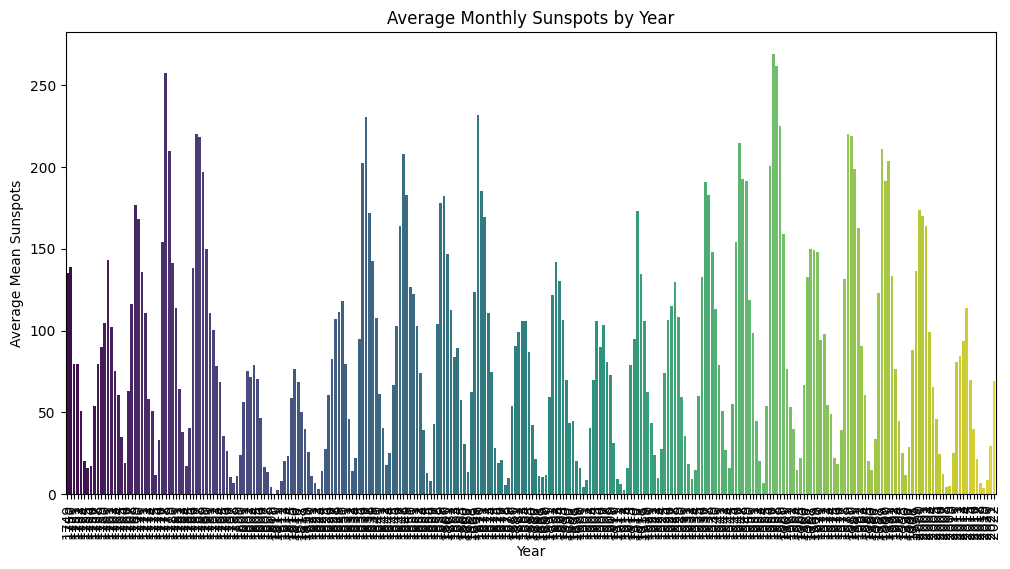

In [188]:
# Group by year and calculate the mean of Sunspots for each year
yearly_avg_sunspots = data1.groupby('Year')['Mean_Sunspots'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_avg_sunspots.index, y=yearly_avg_sunspots.values, palette='viridis')
plt.title('Average Monthly Sunspots by Year')
plt.xlabel('Year')
plt.ylabel('Average Mean Sunspots')
plt.xticks(rotation=90)  # Rotate by 90 degrees for better readability
plt.show()

**Histogram of the Mean Sunspots**

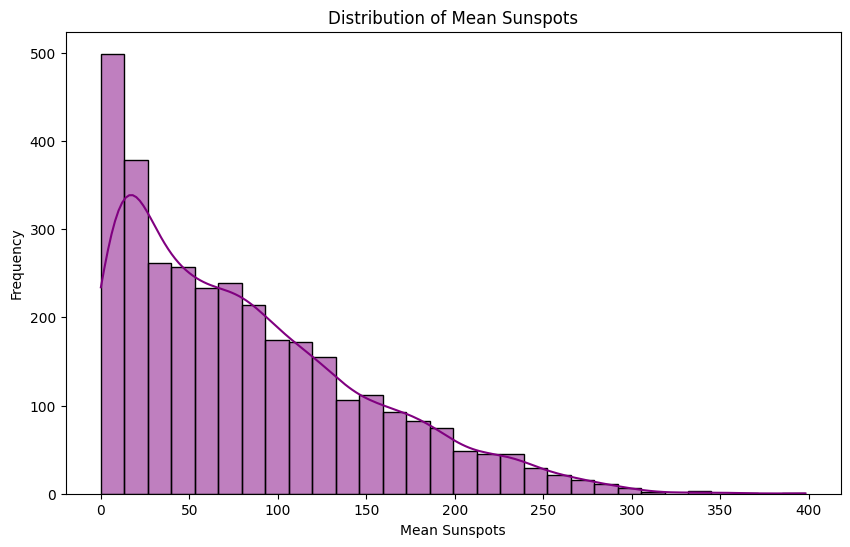

In [154]:
# Histogram of the Mean Sunspots
plt.figure(figsize=(10, 6))
sns.histplot(data1['Mean_Sunspots'], kde=True, color='purple', bins=30)
plt.title('Distribution of Mean Sunspots')
plt.xlabel('Mean Sunspots')
plt.ylabel('Frequency')
plt.show()

**Barplot: Sunspot Values by Year**

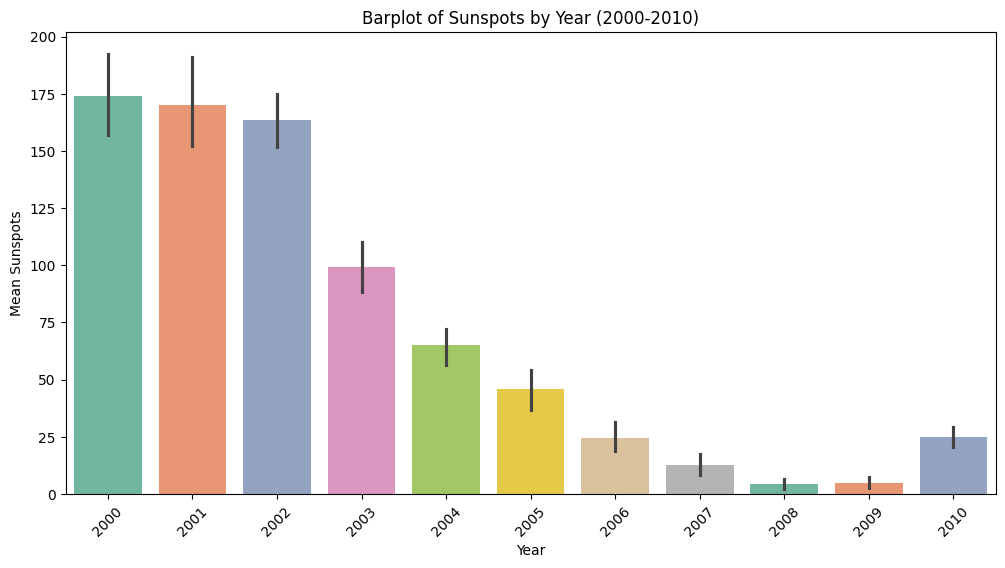

In [189]:
# Filter the data for years between 2000 and 2010 (or any other range you prefer)
filtered_data = data1[data1['Year'].between(2000, 2010)]

# Boxplot for Sunspots values by year for the filtered years
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Mean_Sunspots', data=filtered_data, palette='Set2')
plt.title('Barplot of Sunspots by Year (2000-2010)')
plt.xlabel('Year')
plt.ylabel('Mean Sunspots')
plt.xticks(rotation=45)
plt.show()

**Scatter Plot: Relationship Between Date and Mean Sunspots**

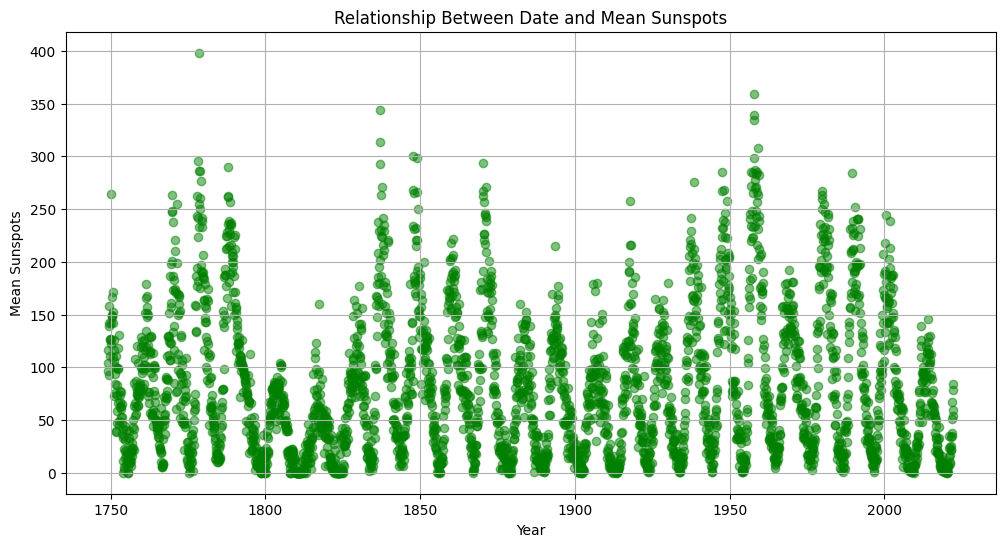

In [156]:
# Scatter plot to see the relationship between Date (Year + Month) and Mean Sunspots
plt.figure(figsize=(12, 6))
plt.scatter(data1['Year'] + data1['Month'] / 12, data1['Mean_Sunspots'], color='green', alpha=0.5)
plt.title('Relationship Between Date and Mean Sunspots')
plt.xlabel('Year')
plt.ylabel('Mean Sunspots')
plt.grid(True)
plt.show()

**Heatmap: Correlation Matrix for Numerical Variables**

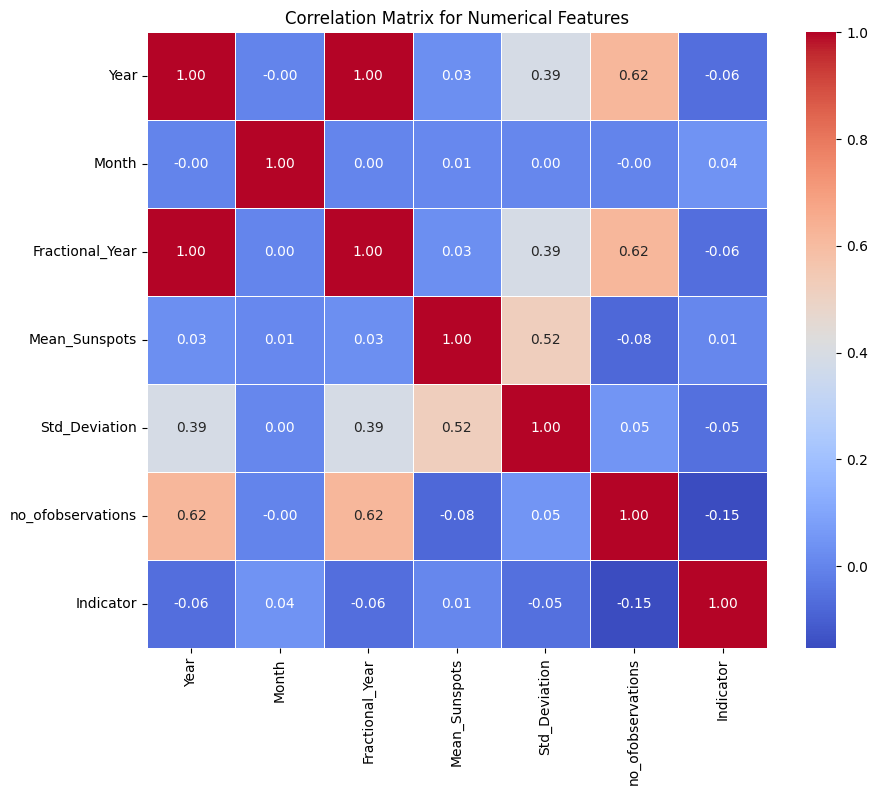

In [157]:
# Calculate the correlation matrix
correlation_matrix = data1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

# **Yearly Data**

In [158]:
# Assume the delimiter is a semicolon (';') as specified in the description
data2 = pd.read_csv(yearly_file, header=None, delimiter=';')

# Assign column names according to the description
column_names = [
    'Year', 'Mean_Sunspot','Std_Dev_Sunspots', 'num_observations', 'Definitive_Provisional_Marker'
]

# Assign the column names to the dataframe
data2.columns = column_names

# Convert numerical columns to appropriate datatypes
for col in ['Year', 'Mean_Sunspot','Std_Dev_Sunspots', 'num_observations', 'Definitive_Provisional_Marker']:
    data2[col] = pd.to_numeric(data2[col], errors='coerce')

# Display the first few rows of the dataset
data2.head()

,Year,Mean_Sunspot,Std_Dev_Sunspots,num_observations,Definitive_Provisional_Marker
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [159]:
data2.shape

(322, 5)

In [160]:
data2.columns

Index(['Year', 'Mean_Sunspot', 'Std_Dev_Sunspots', 'num_observations',
       'Definitive_Provisional_Marker'],
      dtype='object')

In [161]:
data2.describe()

,Year,Mean_Sunspot,Std_Dev_Sunspots,num_observations,Definitive_Provisional_Marker
count,322.000000,322.000000,322.000000,322.000000,322.0
mean,1861.000000,78.365217,4.633540,1113.546584,1.0
std,93.097619,62.054638,5.274608,2574.732653,0.0
min,1700.500000,0.000000,-1.000000,-1.000000,1.0
25%,1780.750000,24.325000,-1.000000,-1.000000,1.0
50%,1861.000000,65.150000,4.150000,365.000000,1.0
75%,1941.250000,115.075000,8.850000,365.000000,1.0
max,2021.500000,269.300000,19.100000,15233.000000,1.0


In [162]:
data2.isnull().sum()

,0
Year,0
Mean_Sunspot,0
Std_Dev_Sunspots,0
num_observations,0
Definitive_Provisional_Marker,0


In [163]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           322 non-null    float64
 1   Mean_Sunspot                   322 non-null    float64
 2   Std_Dev_Sunspots               322 non-null    float64
 3   num_observations               322 non-null    int64  
 4   Definitive_Provisional_Marker  322 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 12.7 KB


In [164]:
# Count rows with invalid Sunspot data (-1)
invalid_sunspots = data2[data2['Mean_Sunspot'] == -1].shape[0]
print(f"Number of rows with invalid Sunspot data (-1): {invalid_sunspots}")

# Filter out invalid Sunspot data
data_cleaned2 = data2[data2['Mean_Sunspot'] >= 0]

Number of rows with invalid Sunspot data (-1): 0


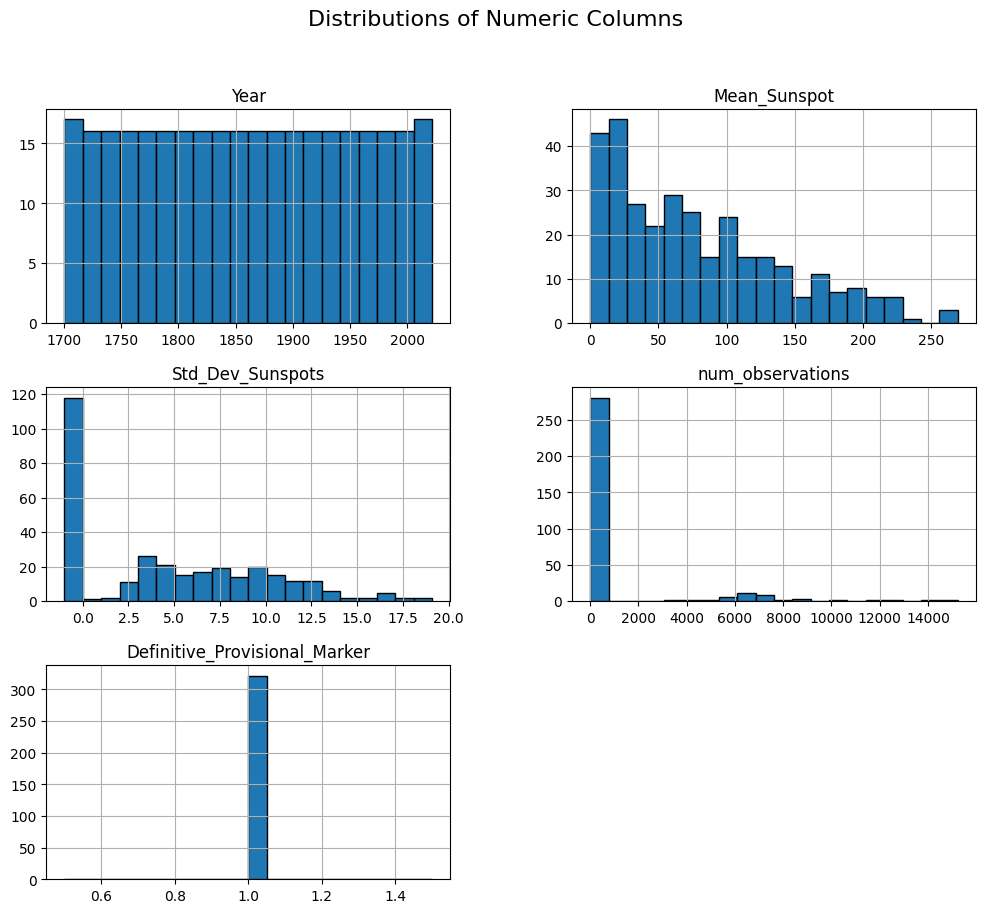

In [165]:
# Plot histograms for numeric columns
data_cleaned2.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Distributions of Numeric Columns", fontsize=16)
plt.show()

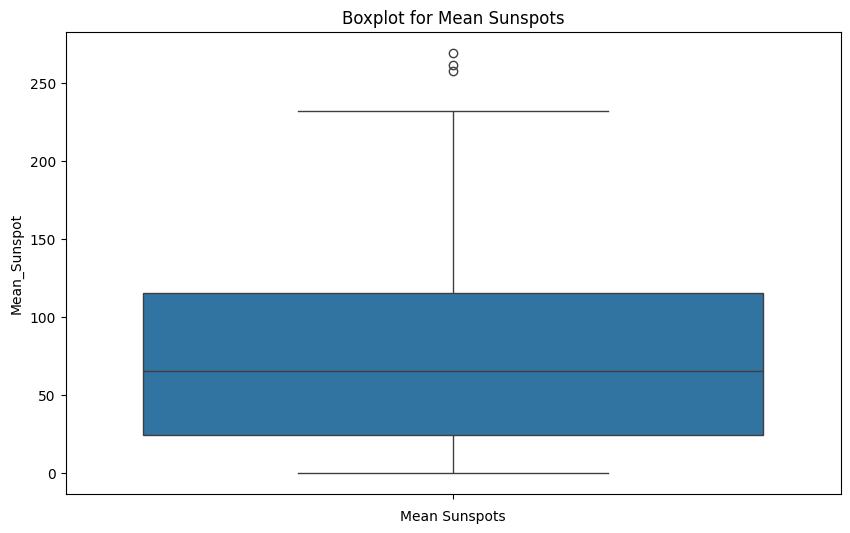

In [166]:
# Create a boxplot to visually check for outliers in 'Mean_Sunspots'
plt.figure(figsize=(10, 6))
sns.boxplot(data2['Mean_Sunspot'])
plt.title("Boxplot for Mean Sunspots")
plt.xlabel("Mean Sunspots")
plt.show()

In [167]:
# Remove outliers based on a threshold
q1 = data_cleaned2['Mean_Sunspot'].quantile(0.25)
q3 = data_cleaned2['Mean_Sunspot'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter data within the bounds
data_no_outliers = data_cleaned2[(data_cleaned2['Mean_Sunspot'] >= lower_bound) & (data_cleaned2['Mean_Sunspot'] <= upper_bound)]
print(f"Number of rows after removing outliers: {data_no_outliers.shape[0]}")

Number of rows after removing outliers: 319


# **Data Visualization (Yearly)**

**Line Plot for Sunspots Over the Years**

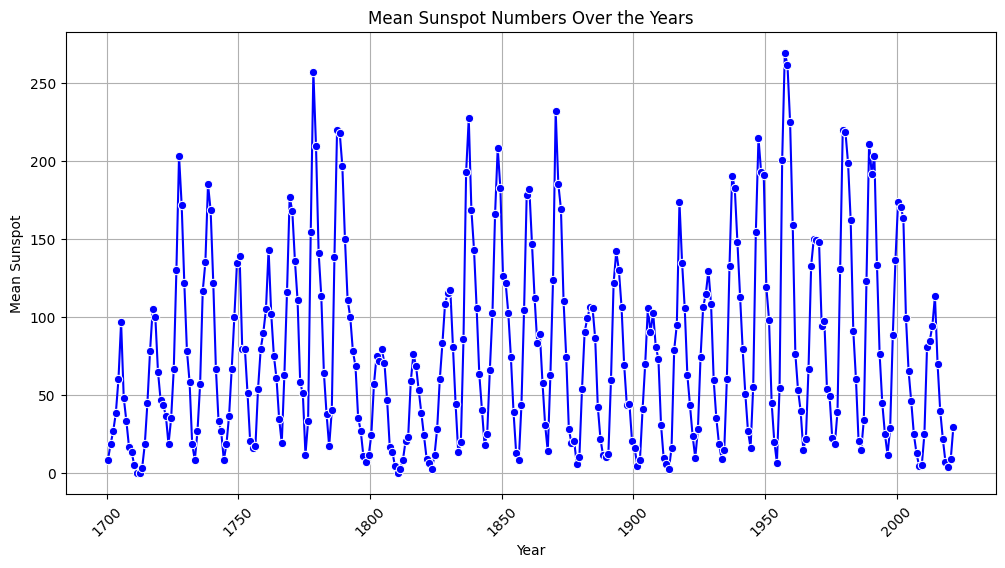

In [168]:
# Line plot for Sunspots over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Mean_Sunspot', data=data2, marker='o', color='b')
plt.title('Mean Sunspot Numbers Over the Years')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Yearly Trends**

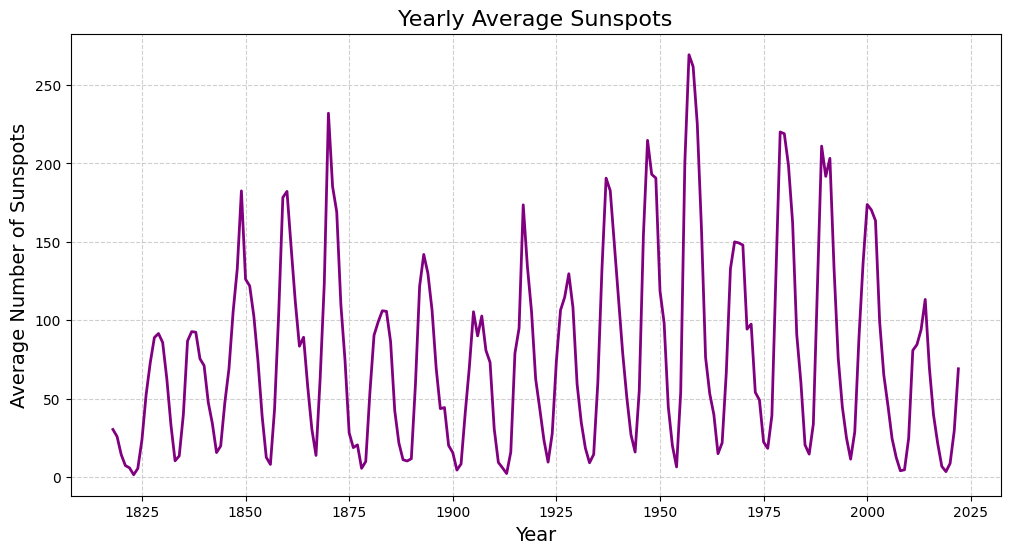

In [169]:
# Group by Year
yearly_avg = data.groupby('Year')['Sunspots'].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_avg.index, yearly_avg.values, color='purple', linewidth=2)
plt.title('Yearly Average Sunspots', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Number of Sunspots', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Histogram for Sunspot Distribution**

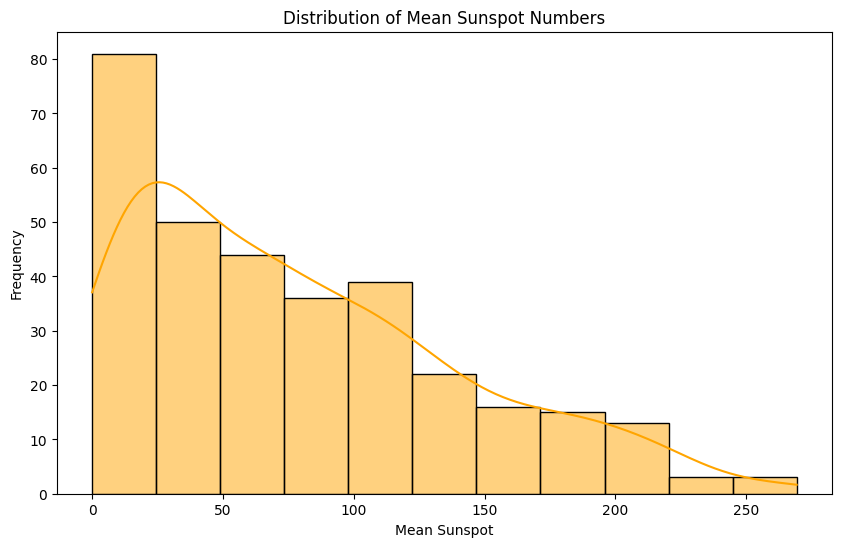

In [170]:
# Histogram for Mean Sunspot Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data2['Mean_Sunspot'], kde=True, color='orange')
plt.title('Distribution of Mean Sunspot Numbers')
plt.xlabel('Mean Sunspot')
plt.ylabel('Frequency')
plt.show()

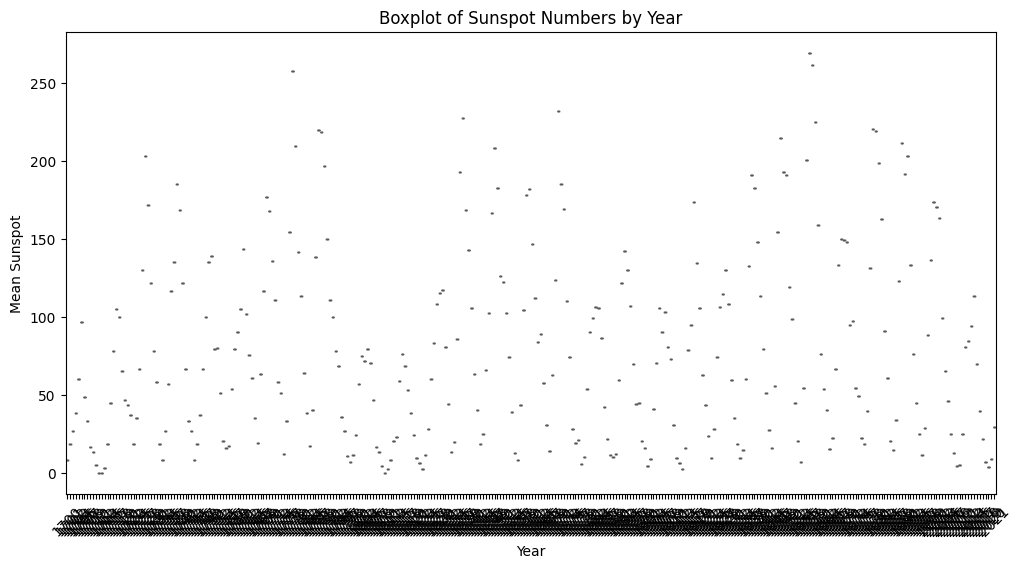

In [190]:
# Boxplot for Mean Sunspot numbers by Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Mean_Sunspot', data=data2, palette='Set2')
plt.title('Boxplot of Sunspot Numbers by Year')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot')
plt.xticks(rotation=45)
plt.show()

**Scatter Plot for Sunspot vs Standard Deviation**

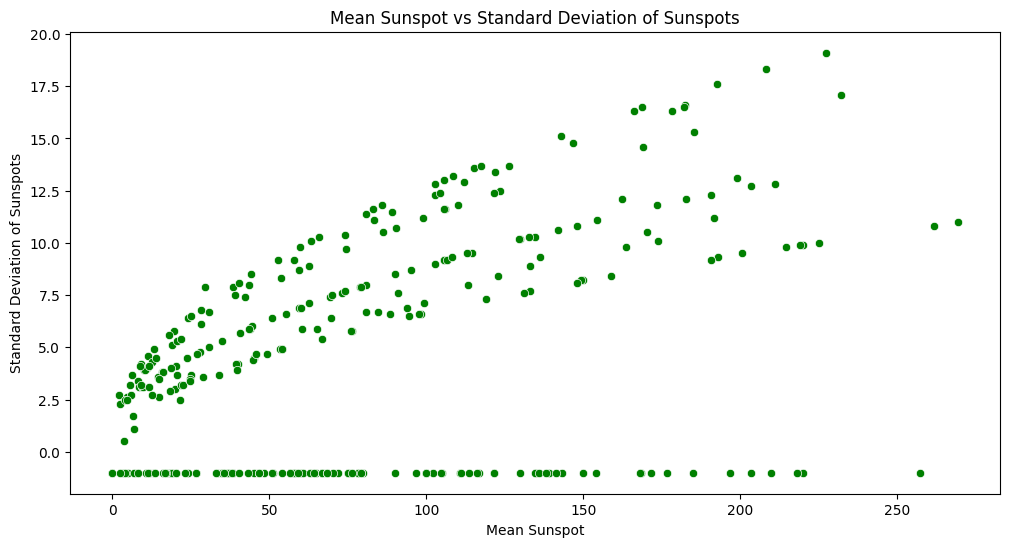

In [172]:
# Scatter plot for Mean Sunspot vs Standard Deviation of Sunspots
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Mean_Sunspot', y='Std_Dev_Sunspots', data=data2, color='green')
plt.title('Mean Sunspot vs Standard Deviation of Sunspots')
plt.xlabel('Mean Sunspot')
plt.ylabel('Standard Deviation of Sunspots')
plt.show()

**Correlation Heatmap for Sunspot-related Variables**

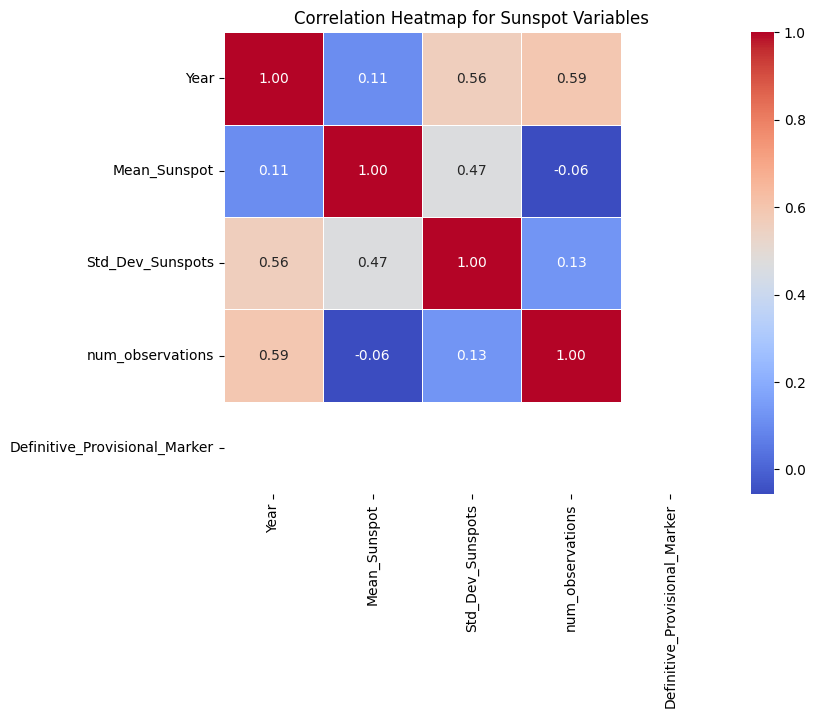

In [173]:
# Correlation heatmap for numerical columns
correlation_matrix = data2[['Year', 'Mean_Sunspot', 'Std_Dev_Sunspots', 'num_observations',
       'Definitive_Provisional_Marker']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for Sunspot Variables')
plt.show()

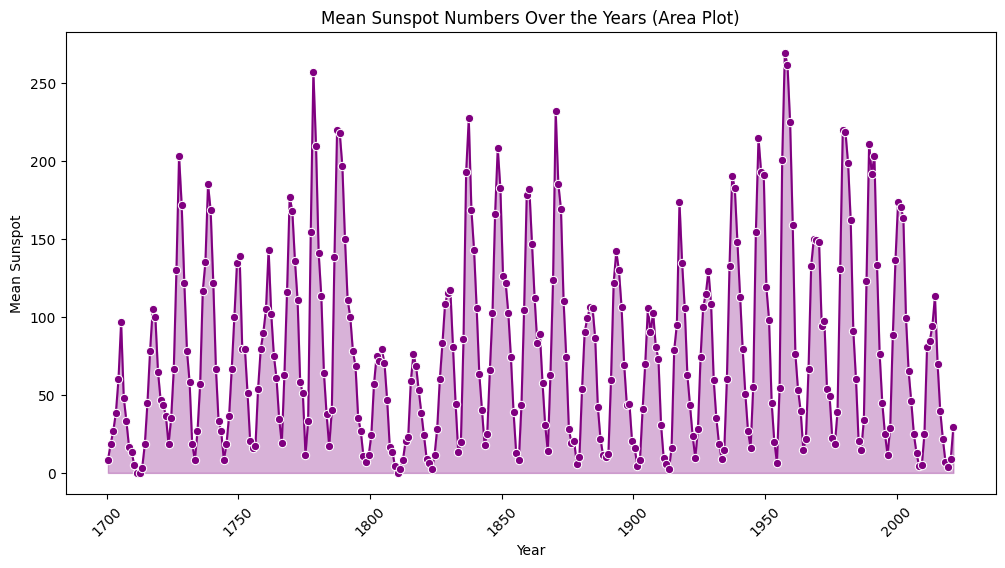

In [174]:
# Area plot for Mean Sunspot over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Mean_Sunspot', data=data2, marker='o', color='purple')
plt.fill_between(data2['Year'], data2['Mean_Sunspot'], color='purple', alpha=0.3)
plt.title('Mean Sunspot Numbers Over the Years (Area Plot)')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot')
plt.xticks(rotation=45)
plt.show()

**Unit of the time series**

In [175]:
# Convert Year/Month/Day to datetime for daily data (data)
if {'Year', 'Month', 'Day'}.issubset(data.columns):
    data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
    print("Daily dataset 'data' updated with 'Date' column.")

# Convert Year/Month to datetime for monthly data (data1)
if {'Year', 'Month'}.issubset(data1.columns):
    data1['Date'] = pd.to_datetime(data1[['Year', 'Month']].assign(Day=1))
    print("Monthly dataset 'data1' updated with 'Date' column.")

# Convert Year to datetime for yearly data (data2)
if 'Year' in data2.columns:
    # Handle fractional years by keeping only the integer part
    data2['Year'] = np.floor(data2['Year']).astype(int)  # Extract integer part
    data2['Date'] = pd.to_datetime(data2['Year'].astype(str) + '-01-01')  # Convert to datetime
    print("Yearly dataset 'data2' updated with 'Date' column.")

# Display the first few rows to confirm
print("\nDaily Data (with Date):")
data.head()

Daily dataset 'data' updated with 'Date' column.
Monthly dataset 'data1' updated with 'Date' column.
Yearly dataset 'data2' updated with 'Date' column.

Daily Data (with Date):


,Year,Month,Day,Fractional_Year,Sunspots,Deviation,no_of_observations,Indicator,Date,Weekday,Quarter,Sunspots_Rolling
0,1818,1,1,1818.001,-1,-1.0,0,1,1818-01-01,Thursday,1,NaN
1,1818,1,2,1818.004,-1,-1.0,0,1,1818-01-02,Friday,1,NaN
2,1818,1,3,1818.007,-1,-1.0,0,1,1818-01-03,Saturday,1,NaN
3,1818,1,4,1818.010,-1,-1.0,0,1,1818-01-04,Sunday,1,NaN
4,1818,1,5,1818.012,-1,-1.0,0,1,1818-01-05,Monday,1,NaN


In [176]:
print("\nMonthly Data (with Date):")
data1.head()


Monthly Data (with Date):


,Year,Month,Fractional_Year,Mean_Sunspots,Std_Deviation,no_ofobservations,Indicator,Date
0,1749,1,1749.042,96.7,-1.0,-1,1,1749-01-01
1,1749,2,1749.123,104.3,-1.0,-1,1,1749-02-01
2,1749,3,1749.204,116.7,-1.0,-1,1,1749-03-01
3,1749,4,1749.288,92.8,-1.0,-1,1,1749-04-01
4,1749,5,1749.371,141.7,-1.0,-1,1,1749-05-01


In [177]:
print("\nYearly Data (with Date):")
data2.head()


Yearly Data (with Date):


,Year,Mean_Sunspot,Std_Dev_Sunspots,num_observations,Definitive_Provisional_Marker,Date
0,1700,8.3,-1.0,-1,1,1700-01-01
1,1701,18.3,-1.0,-1,1,1701-01-01
2,1702,26.7,-1.0,-1,1,1702-01-01
3,1703,38.3,-1.0,-1,1,1703-01-01
4,1704,60.0,-1.0,-1,1,1704-01-01


# **Training and Prediction**

# **Daily Data**

**Logistic Model Growth**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/dz_sqkgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/t2v43k9m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39260', 'data', 'file=/tmp/tmp8zlfe3ql/dz_sqkgd.json', 'init=/tmp/tmp8zlfe3ql/t2v43k9m.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_model2wyefilb/prophet_model-20241129160153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


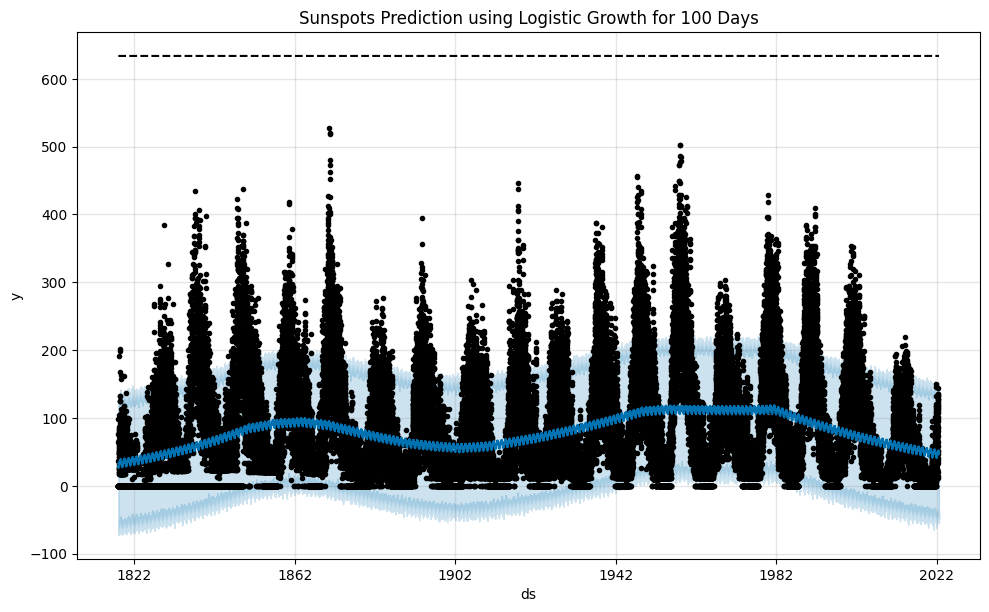

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/rz5b_k6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/nsgfe8bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58931', 'data', 'file=/tmp/tmp8zlfe3ql/rz5b_k6d.json', 'init=/tmp/tmp8zlfe3ql/nsgfe8bz.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modelglx_t6lr/prophet_model-20241129164025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:40:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


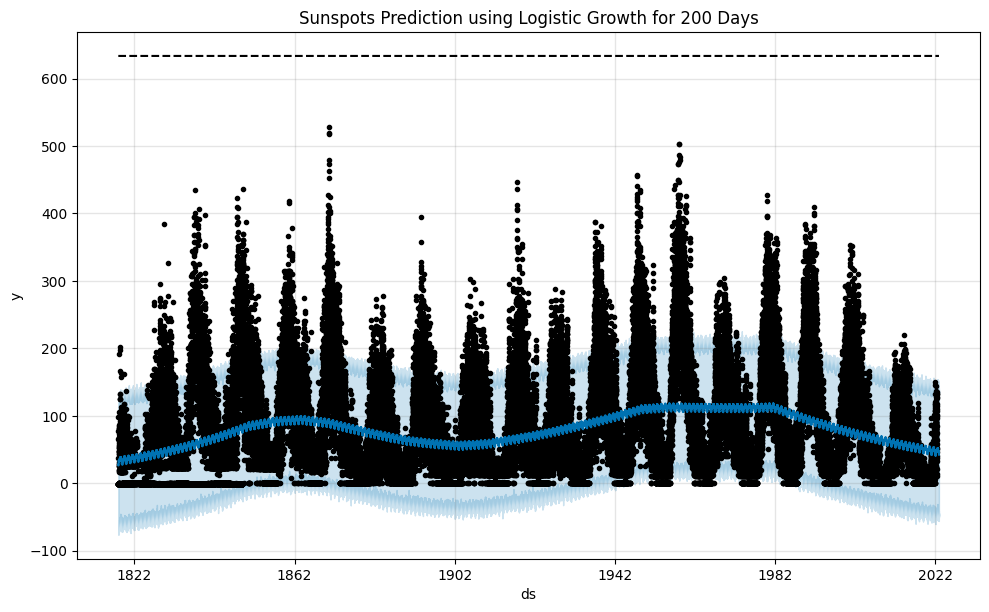

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/62o45ums.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/gj350o_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78239', 'data', 'file=/tmp/tmp8zlfe3ql/62o45ums.json', 'init=/tmp/tmp8zlfe3ql/gj350o_i.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_model4v0lc5rz/prophet_model-20241129171904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


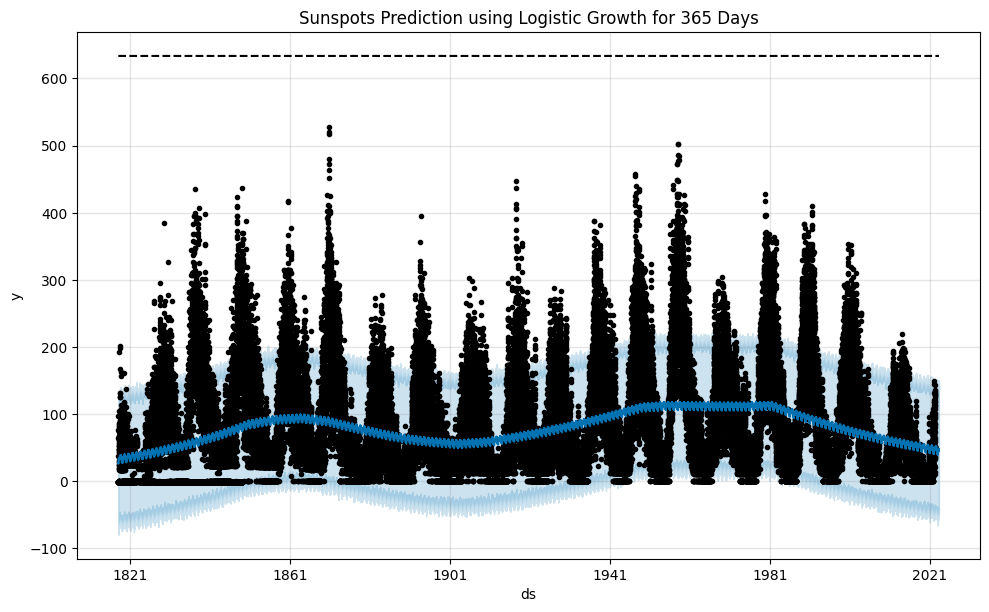

Prediction for 100 days:
              ds       yhat  yhat_lower  yhat_upper
74725 2022-08-04  47.762647  -44.169410  130.328842
74726 2022-08-05  47.566331  -49.053478  138.433881
74727 2022-08-06  48.370887  -48.292978  141.625938
74728 2022-08-07  48.443434  -49.680804  139.578787
74729 2022-08-08  48.972696  -45.011059  143.748861

Prediction for 200 days:
              ds       yhat  yhat_lower  yhat_upper
74825 2022-11-12  43.303598  -50.838981  138.173378
74826 2022-11-13  42.768062  -51.029198  138.542236
74827 2022-11-14  42.687796  -43.967676  133.315840
74828 2022-11-15  42.335629  -48.054596  134.952860
74829 2022-11-16  42.306508  -48.988365  135.674468

Prediction for 365 days:
              ds       yhat  yhat_lower  yhat_upper
74990 2023-04-26  47.547508  -43.739856  136.630223
74991 2023-04-27  47.618507  -43.559180  139.533711
74992 2023-04-28  47.326030  -40.013425  139.065000
74993 2023-04-29  48.009675  -40.874982  142.634339
74994 2023-04-30  47.938620  -39.450221

In [100]:
# Prepare the data for Prophet
# Rename the columns as Prophet expects 'ds' for the datetime column and 'y' for the target column
daily_data_prophet = data[['Date', 'Sunspots']].rename(columns={'Date': 'ds', 'Sunspots': 'y'})

# Add the 'cap' column (required for logistic growth)
# Set capacity to 120% of the maximum sunspot value (you can adjust this if needed)
max_capacity = daily_data_prophet['y'].max() * 1.2
daily_data_prophet['cap'] = max_capacity

# Train and predict using Logistic growth model
def train_and_predict_logistic(daily_data, periods):
    # Initialize the Prophet model with logistic growth
    prophet_model = Prophet(growth='logistic')

    # Fit the model on the data
    prophet_model.fit(daily_data)

    # Create a future dataframe for predictions (next 'periods' days)
    future = prophet_model.make_future_dataframe(periods=periods, freq='D')  # Set the frequency to 'D' for daily data

    # Add the 'cap' column to the future dataframe (required for logistic growth)
    future['cap'] = max_capacity

    # Forecast
    forecast = prophet_model.predict(future)

    # Plot the forecast
    fig = prophet_model.plot(forecast)
    plt.title(f"Sunspots Prediction using Logistic Growth for {periods} Days")
    plt.show()

    return forecast

# Predict for 100, 200, and 365 days into the future
forecast_100 = train_and_predict_logistic(daily_data_prophet, 100)
forecast_200 = train_and_predict_logistic(daily_data_prophet, 200)
forecast_365 = train_and_predict_logistic(daily_data_prophet, 365)

# Display the last few predictions for each forecast
print("Prediction for 100 days:")
print(forecast_100[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("\nPrediction for 200 days:")
print(forecast_200[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("\nPrediction for 365 days:")
print(forecast_365[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

**Linear Model Growth**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/mgne6nnn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/4the6c10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45589', 'data', 'file=/tmp/tmp8zlfe3ql/mgne6nnn.json', 'init=/tmp/tmp8zlfe3ql/4the6c10.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modelz8pdir05/prophet_model-20241129180004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8z

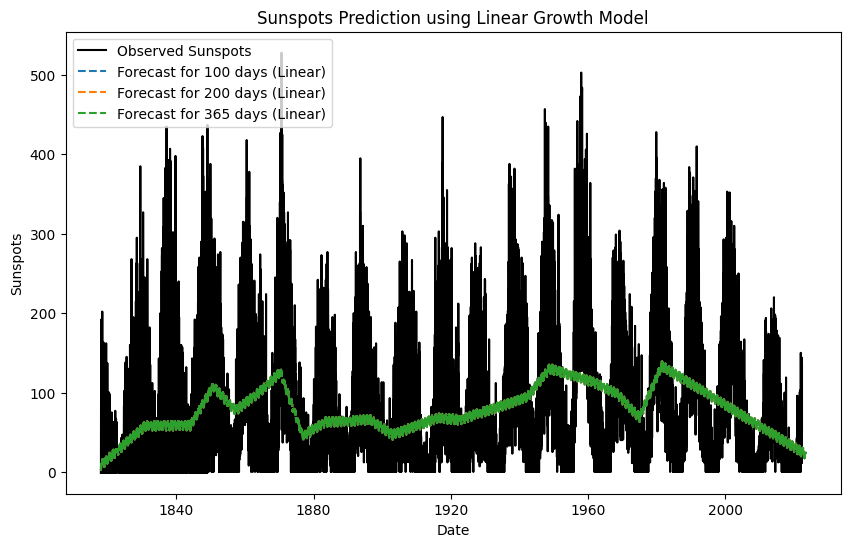

Prediction for 100 days (Linear Growth):
              ds       yhat  yhat_lower  yhat_upper
74725 2022-08-04  25.722217  -61.349022  112.564833
74726 2022-08-05  25.522261  -58.364998  116.272264
74727 2022-08-06  26.323432  -67.235444  112.099656
74728 2022-08-07  26.390271  -66.538512  122.977829
74729 2022-08-08  26.916063  -61.545867  122.617858

Prediction for 200 days (Linear Growth):
              ds       yhat  yhat_lower  yhat_upper
74825 2022-11-12  20.838148  -66.904094  117.507365
74826 2022-11-13  20.296523  -69.242283  114.434062
74827 2022-11-14  20.212597  -74.269747  107.395379
74828 2022-11-15  19.856818  -68.209967  109.835035
74829 2022-11-16  19.824312  -64.864251  117.617698

Prediction for 365 days (Linear Growth):
              ds       yhat  yhat_lower  yhat_upper
74990 2023-04-26  24.424509  -69.107827  113.004522
74991 2023-04-27  24.488048  -59.739359  115.918840
74992 2023-04-28  24.185442  -67.123324  118.516249
74993 2023-04-29  24.858966  -66.831285  11

In [101]:
# Prepare the data for Prophet
daily_data_prophet = data[['Date', 'Sunspots']].rename(columns={'Date': 'ds', 'Sunspots': 'y'})

# Train and predict using Linear growth model
def train_and_predict_linear(daily_data, periods):
    # Initialize the Prophet model with linear growth
    prophet_model = Prophet(growth='linear')

    # Fit the model on the data
    prophet_model.fit(daily_data)

    # Create a future dataframe for predictions (next 'periods' days)
    future = prophet_model.make_future_dataframe(periods=periods, freq='D')  # Set the frequency to 'D' for daily data

    # Forecast
    forecast = prophet_model.predict(future)

    return forecast, prophet_model

# Predict for 100, 200, and 365 days into the future using Linear Growth
forecast_100_linear, model_100_linear = train_and_predict_linear(daily_data_prophet, 100)
forecast_200_linear, model_200_linear = train_and_predict_linear(daily_data_prophet, 200)
forecast_365_linear, model_365_linear = train_and_predict_linear(daily_data_prophet, 365)

# Plot the Linear Growth forecast
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(daily_data_prophet['ds'], daily_data_prophet['y'], label='Observed Sunspots', color='black')

# Plot the forecasted data for 100, 200, and 365 days
plt.plot(forecast_100_linear['ds'], forecast_100_linear['yhat'], label='Forecast for 100 days (Linear)', linestyle='--')
plt.plot(forecast_200_linear['ds'], forecast_200_linear['yhat'], label='Forecast for 200 days (Linear)', linestyle='--')
plt.plot(forecast_365_linear['ds'], forecast_365_linear['yhat'], label='Forecast for 365 days (Linear)', linestyle='--')

# Add titles and labels
plt.title('Sunspots Prediction using Linear Growth Model')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()

# Show the plot
plt.show()

# Display the last few predictions for each forecast
print("Prediction for 100 days (Linear Growth):")
print(forecast_100_linear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("\nPrediction for 200 days (Linear Growth):")
print(forecast_200_linear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("\nPrediction for 365 days (Linear Growth):")
print(forecast_365_linear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

**Flat Model Prediction**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/yawzhz6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/nfedyy7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67670', 'data', 'file=/tmp/tmp8zlfe3ql/yawzhz6v.json', 'init=/tmp/tmp8zlfe3ql/nfedyy7j.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modeliy3xzxbo/prophet_model-20241129180609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8z

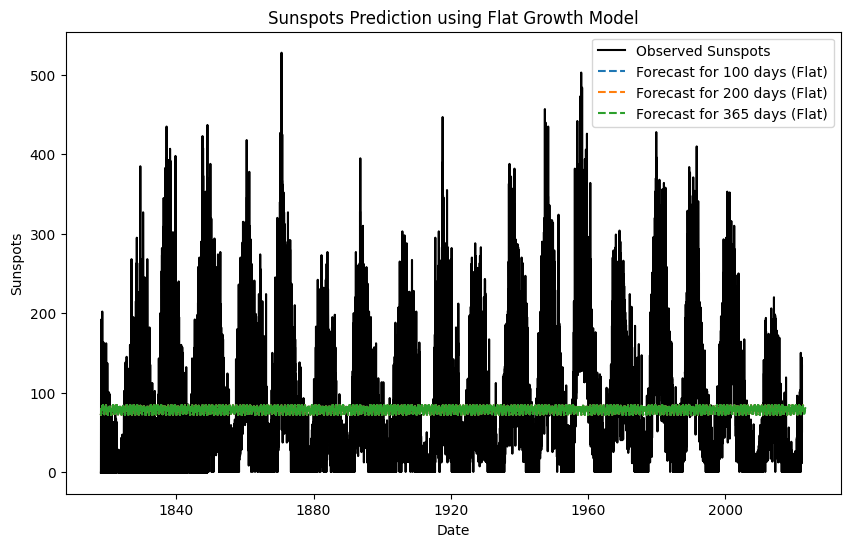

Prediction for 100 days (Flat Growth):
              ds       yhat  yhat_lower  yhat_upper
74725 2022-08-04  79.690489  -21.820623  183.603864
74726 2022-08-05  79.496390  -19.491909  177.336346
74727 2022-08-06  80.302689  -16.908052  175.290134
74728 2022-08-07  80.380272  -22.894068  175.934141
74729 2022-08-08  80.911480   -7.943118  178.137846

Prediction for 200 days (Flat Growth):
              ds       yhat  yhat_lower  yhat_upper
74825 2022-11-12  75.546600  -22.393944  185.038682
74826 2022-11-13  75.016651  -23.598666  169.912466
74827 2022-11-14  74.938531  -34.707802  179.101001
74828 2022-11-15  74.588353  -17.911465  175.429233
74829 2022-11-16  74.560851  -21.343111  177.057024

Prediction for 365 days (Flat Growth):
              ds       yhat  yhat_lower  yhat_upper
74990 2023-04-26  80.098561  -13.624456  179.333045
74991 2023-04-27  80.175780  -19.647633  179.187637
74992 2023-04-28  79.894381  -20.418579  175.361251
74993 2023-04-29  80.588993  -25.087335  184.1045

In [102]:
daily_data_prophet = data[['Date', 'Sunspots']].rename(columns={'Date': 'ds', 'Sunspots': 'y'})

# Train and predict using Flat growth model
def train_and_predict_flat(daily_data, periods):
    # Initialize the Prophet model with flat growth
    prophet_model = Prophet(growth='flat')

    # Fit the model on the data
    prophet_model.fit(daily_data)

    # Create a future dataframe for predictions (next 'periods' days)
    future = prophet_model.make_future_dataframe(periods=periods, freq='D')  # Set the frequency to 'D' for daily data

    # Forecast
    forecast = prophet_model.predict(future)

    return forecast, prophet_model

# Predict for 100, 200, and 365 days into the future using Flat Growth
forecast_100_flat, model_100_flat = train_and_predict_flat(daily_data_prophet, 100)
forecast_200_flat, model_200_flat = train_and_predict_flat(daily_data_prophet, 200)
forecast_365_flat, model_365_flat = train_and_predict_flat(daily_data_prophet, 365)

# Plot the Flat Growth forecast
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(daily_data_prophet['ds'], daily_data_prophet['y'], label='Observed Sunspots', color='black')

# Plot the forecasted data for 100, 200, and 365 days
plt.plot(forecast_100_flat['ds'], forecast_100_flat['yhat'], label='Forecast for 100 days (Flat)', linestyle='--')
plt.plot(forecast_200_flat['ds'], forecast_200_flat['yhat'], label='Forecast for 200 days (Flat)', linestyle='--')
plt.plot(forecast_365_flat['ds'], forecast_365_flat['yhat'], label='Forecast for 365 days (Flat)', linestyle='--')

# Add titles and labels
plt.title('Sunspots Prediction using Flat Growth Model')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()

# Show the plot
plt.show()

# Display the last few predictions for each forecast
print("Prediction for 100 days (Flat Growth):")
print(forecast_100_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("\nPrediction for 200 days (Flat Growth):")
print(forecast_200_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("\nPrediction for 365 days (Flat Growth):")
print(forecast_365_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# **Monthly Data**

**Logistic Model Growth**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/pf6tklk0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/snq4ttil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39667', 'data', 'file=/tmp/tmp8zlfe3ql/pf6tklk0.json', 'init=/tmp/tmp8zlfe3ql/snq4ttil.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modele9efpc70/prophet_model-20241129180915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

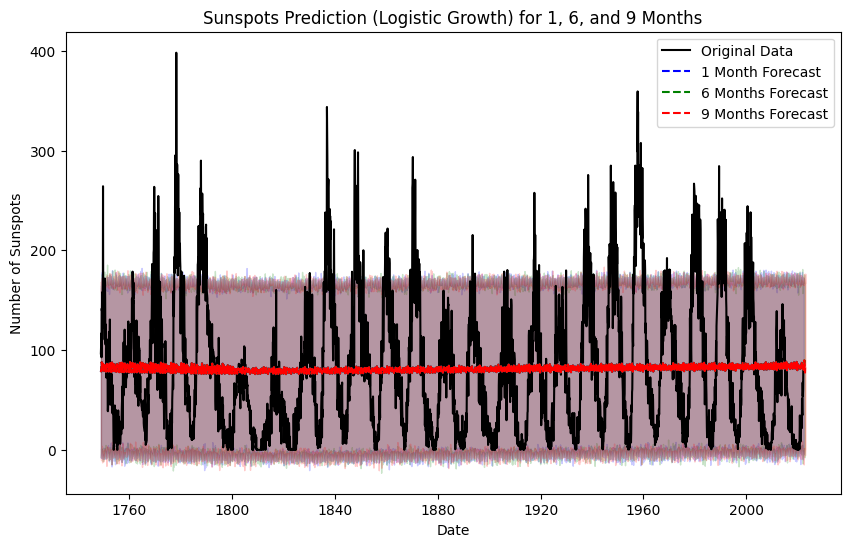

             ds       yhat  yhat_lower  yhat_upper
3276 2022-01-01  81.420578   -9.538403  166.990935
3277 2022-02-01  84.983743   -3.934655  167.160658
3278 2022-03-01  84.023970   -1.493937  172.946870
3279 2022-04-01  83.121212   -4.037202  172.214579
3280 2022-04-30  80.272167   -0.671757  170.744322
             ds       yhat  yhat_lower  yhat_upper
3281 2022-05-31  85.028614   -5.460964  172.772530
3282 2022-06-30  86.343766   -7.195521  175.796816
3283 2022-07-31  89.743803    1.903164  174.410417
3284 2022-08-31  86.573382   -3.691477  169.476676
3285 2022-09-30  86.408332   -7.278101  167.583317
             ds       yhat  yhat_lower  yhat_upper
3284 2022-08-31  86.573382    1.274271  170.814440
3285 2022-09-30  86.408332   -1.673037  172.545170
3286 2022-10-31  77.447934   -5.378414  166.977330
3287 2022-11-30  83.793371   -2.213140  176.707427
3288 2022-12-31  82.685850    1.164350  171.680098


In [105]:
# Prepare the data for Prophet
data1_prophet = data1[['Date', 'Mean_Sunspots']].rename(columns={'Date': 'ds', 'Mean_Sunspots': 'y'})

# Add the 'cap' column for logistic growth (adjust capacity as needed)
max_capacity = data1_prophet['y'].max() * 1.2
data1_prophet['cap'] = max_capacity

# Initialize the Prophet model with logistic growth
prophet_model_logistic = Prophet(growth='logistic')

# Fit the model on the data
prophet_model_logistic.fit(data1_prophet)

# Predict for 1, 6, and 9 months into the future
def predict_logistic_growth(periods):
    # Create future dataframe
    future = prophet_model_logistic.make_future_dataframe(periods=periods, freq='M')

    # Add the 'cap' column to the future dataframe
    future['cap'] = max_capacity

    # Forecast
    forecast = prophet_model_logistic.predict(future)

    return forecast

# Get the predictions for 1, 6, and 9 months
forecast_logistic_1 = predict_logistic_growth(1)
forecast_logistic_6 = predict_logistic_growth(6)
forecast_logistic_9 = predict_logistic_growth(9)

# Plot the original data and all three forecasts on one graph
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(data1_prophet['ds'], data1_prophet['y'], label="Original Data", color='black')

# Plot the forecasts for 1, 6, and 9 months
plt.plot(forecast_logistic_1['ds'], forecast_logistic_1['yhat'], label="1 Month Forecast", linestyle='--', color='blue')
plt.plot(forecast_logistic_6['ds'], forecast_logistic_6['yhat'], label="6 Months Forecast", linestyle='--', color='green')
plt.plot(forecast_logistic_9['ds'], forecast_logistic_9['yhat'], label="9 Months Forecast", linestyle='--', color='red')

# Add confidence intervals for each forecast
plt.fill_between(forecast_logistic_1['ds'], forecast_logistic_1['yhat_lower'], forecast_logistic_1['yhat_upper'], color='blue', alpha=0.2)
plt.fill_between(forecast_logistic_6['ds'], forecast_logistic_6['yhat_lower'], forecast_logistic_6['yhat_upper'], color='green', alpha=0.2)
plt.fill_between(forecast_logistic_9['ds'], forecast_logistic_9['yhat_lower'], forecast_logistic_9['yhat_upper'], color='red', alpha=0.2)

# Adding labels and title
plt.title("Sunspots Prediction (Logistic Growth) for 1, 6, and 9 Months")
plt.xlabel("Date")
plt.ylabel("Number of Sunspots")
plt.legend()

# Show the plot
plt.show()

# Print the last few rows of predictions for each forecast
print(forecast_logistic_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print(forecast_logistic_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print(forecast_logistic_9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

**Linear Model Growth**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/mkm4i6tz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/nzi3k74t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53440', 'data', 'file=/tmp/tmp8zlfe3ql/mkm4i6tz.json', 'init=/tmp/tmp8zlfe3ql/nzi3k74t.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modelo0ejuo6f/prophet_model-20241129181506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

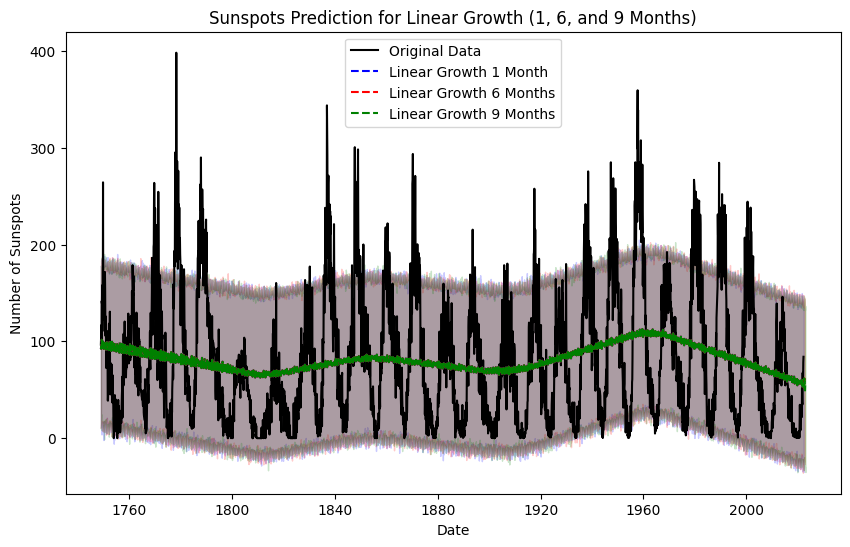

             ds       yhat  yhat_lower  yhat_upper
3276 2022-01-01  53.981036  -27.534235  141.306668
3277 2022-02-01  57.449821  -27.549105  145.844839
3278 2022-03-01  56.692487  -23.330014  138.781972
3279 2022-04-01  55.565771  -24.901774  137.616343
3280 2022-04-30  52.455930  -34.676854  131.380368
             ds       yhat  yhat_lower  yhat_upper
3281 2022-05-31  57.063391  -21.866214  140.473550
3282 2022-06-30  58.550802  -23.303257  145.457875
3283 2022-07-31  61.757182  -20.381355  144.254751
3284 2022-08-31  58.506046  -26.646204  143.014605
3285 2022-09-30  58.549913  -23.760922  140.597330
             ds       yhat  yhat_lower  yhat_upper
3284 2022-08-31  58.506046  -25.106558  144.128313
3285 2022-09-30  58.549913  -24.257920  140.170538
3286 2022-10-31  49.288572  -32.476939  132.401273
3287 2022-11-30  55.588565  -29.609485  136.743262
3288 2022-12-31  54.159313  -34.971322  132.115618


In [111]:
# Prepare the data for Prophet
data1_prophet = data1[['Date', 'Mean_Sunspots']].rename(columns={'Date': 'ds', 'Mean_Sunspots': 'y'})

# Initialize the Prophet model for linear growth
prophet_model_linear = Prophet(growth='linear')

# Fit the model on the data
prophet_model_linear.fit(data1_prophet)

# Predict function for the linear model
def predict_linear_growth(periods):
    # Create future dataframe
    future = prophet_model_linear.make_future_dataframe(periods=periods, freq='M')

    # Forecast
    forecast = prophet_model_linear.predict(future)

    return forecast

# Get the predictions for 1, 6, and 9 months
forecast_linear_1 = predict_linear_growth(1)
forecast_linear_6 = predict_linear_growth(6)
forecast_linear_9 = predict_linear_growth(9)

# Plot the original data and the linear growth forecasts
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(data1_prophet['ds'], data1_prophet['y'], label="Original Data", color='black')

# Plot the forecasts for 1, 6, and 9 months
plt.plot(forecast_linear_1['ds'], forecast_linear_1['yhat'], label="Linear Growth 1 Month", linestyle='--', color='blue')
plt.plot(forecast_linear_6['ds'], forecast_linear_6['yhat'], label="Linear Growth 6 Months", linestyle='--', color='red')
plt.plot(forecast_linear_9['ds'], forecast_linear_9['yhat'], label="Linear Growth 9 Months", linestyle='--', color='green')

# Add confidence intervals for the forecast
plt.fill_between(forecast_linear_1['ds'], forecast_linear_1['yhat_lower'], forecast_linear_1['yhat_upper'], color='blue', alpha=0.2)
plt.fill_between(forecast_linear_6['ds'], forecast_linear_6['yhat_lower'], forecast_linear_6['yhat_upper'], color='red', alpha=0.2)
plt.fill_between(forecast_linear_9['ds'], forecast_linear_9['yhat_lower'], forecast_linear_9['yhat_upper'], color='green', alpha=0.2)

# Adding labels and title
plt.title("Sunspots Prediction for Linear Growth (1, 6, and 9 Months)")
plt.xlabel("Date")
plt.ylabel("Number of Sunspots")
plt.legend()

# Show the plot
plt.show()

# Print the last few rows of the forecast
print(forecast_linear_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print(forecast_linear_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print(forecast_linear_9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

**Flat Model Growth**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/p2djcziw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/jadurtxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65313', 'data', 'file=/tmp/tmp8zlfe3ql/p2djcziw.json', 'init=/tmp/tmp8zlfe3ql/jadurtxq.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modelnsqf_iy2/prophet_model-20241129181443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

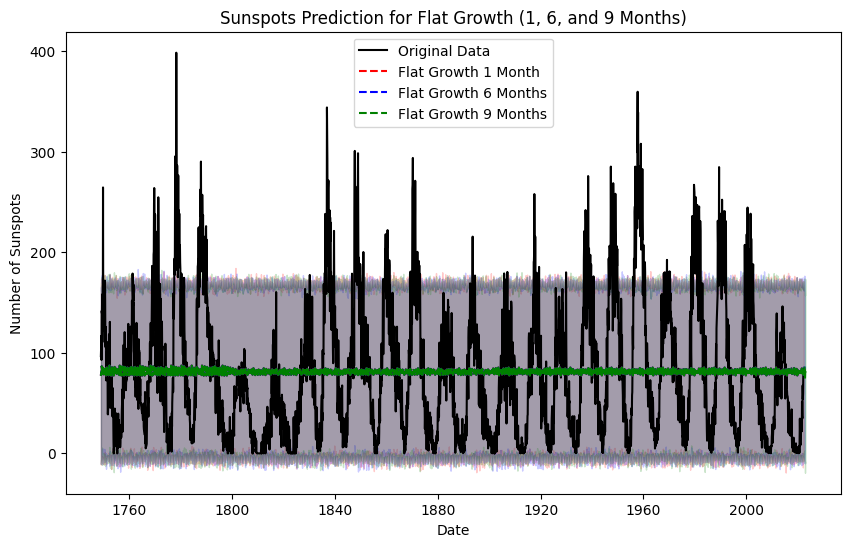

             ds       yhat  yhat_lower  yhat_upper
3276 2022-01-01  78.658760  -13.935290  165.260750
3277 2022-02-01  81.988410   -3.702921  166.183838
3278 2022-03-01  81.061268   -4.541874  171.304613
3279 2022-04-01  80.519923   -6.860031  163.619879
3280 2022-04-30  78.023206   -7.715288  166.689549
             ds       yhat  yhat_lower  yhat_upper
3281 2022-05-31  82.013075   -3.975932  175.557490
3282 2022-06-30  83.586325   -7.645093  167.272698
3283 2022-07-31  86.642656   -0.344396  176.573004
3284 2022-08-31  83.544463   -1.120964  173.469916
3285 2022-09-30  83.329277  -10.015892  170.185757
             ds       yhat  yhat_lower  yhat_upper
3284 2022-08-31  83.544463    3.017375  169.353790
3285 2022-09-30  83.329277   -3.503922  163.234802
3286 2022-10-31  75.177058  -19.243182  157.068335
3287 2022-11-30  81.466738   -8.159880  173.333668
3288 2022-12-31  79.879755   -9.244000  160.898968


In [110]:
# Prepare the data for Prophet
data1_prophet = data1[['Date', 'Mean_Sunspots']].rename(columns={'Date': 'ds', 'Mean_Sunspots': 'y'})

# Initialize the Prophet model for flat growth
prophet_model_flat = Prophet(growth='flat')

# Fit the model on the data
prophet_model_flat.fit(data1_prophet)

# Predict function for the flat model
def predict_flat_growth(periods):
    # Create future dataframe
    future = prophet_model_flat.make_future_dataframe(periods=periods, freq='M')

    # Forecast
    forecast = prophet_model_flat.predict(future)

    return forecast

# Get the predictions for 1, 6, and 9 months
forecast_flat_1 = predict_flat_growth(1)
forecast_flat_6 = predict_flat_growth(6)
forecast_flat_9 = predict_flat_growth(9)

# Plot the original data and the flat growth forecasts
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(data1_prophet['ds'], data1_prophet['y'], label="Original Data", color='black')

# Plot the forecasts for 1, 6, and 9 months
plt.plot(forecast_flat_1['ds'], forecast_flat_1['yhat'], label="Flat Growth 1 Month", linestyle='--', color='red')
plt.plot(forecast_flat_6['ds'], forecast_flat_6['yhat'], label="Flat Growth 6 Months", linestyle='--', color='blue')
plt.plot(forecast_flat_9['ds'], forecast_flat_9['yhat'], label="Flat Growth 9 Months", linestyle='--', color='green')

# Add confidence intervals for the forecast
plt.fill_between(forecast_flat_1['ds'], forecast_flat_1['yhat_lower'], forecast_flat_1['yhat_upper'], color='red', alpha=0.2)
plt.fill_between(forecast_flat_6['ds'], forecast_flat_6['yhat_lower'], forecast_flat_6['yhat_upper'], color='blue', alpha=0.2)
plt.fill_between(forecast_flat_9['ds'], forecast_flat_9['yhat_lower'], forecast_flat_9['yhat_upper'], color='green', alpha=0.2)

# Adding labels and title
plt.title("Sunspots Prediction for Flat Growth (1, 6, and 9 Months)")
plt.xlabel("Date")
plt.ylabel("Number of Sunspots")
plt.legend()

# Show the plot
plt.show()

# Print the last few rows of the forecast
print(forecast_flat_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print(forecast_flat_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print(forecast_flat_9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# **Yearly Data**

**Logistic Model Growth**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/el9yy7ih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/widl7yoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71728', 'data', 'file=/tmp/tmp8zlfe3ql/el9yy7ih.json', 'init=/tmp/tmp8zlfe3ql/widl7yoy.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modelbop60ejf/prophet_model-20241129182318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:18 - cmdstanpy - INFO - Chain

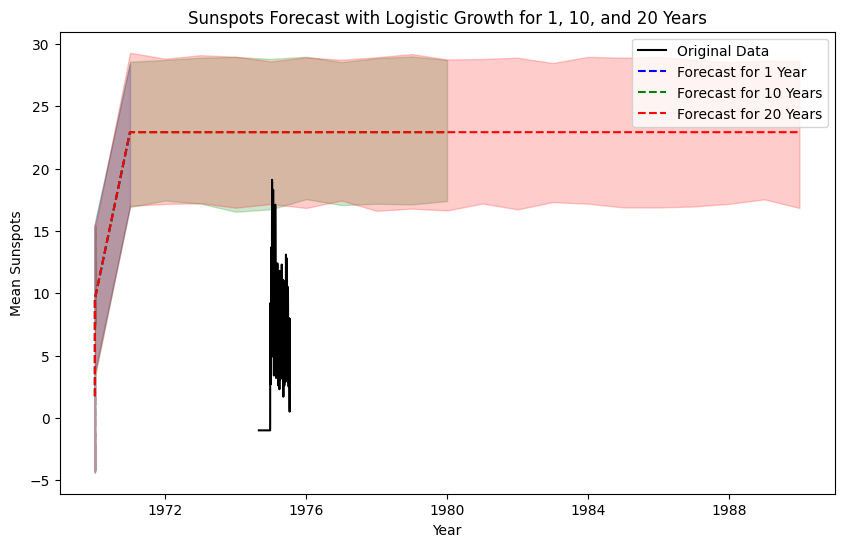

                               ds       yhat  yhat_lower  yhat_upper
318 1970-01-01 00:00:00.000002018   9.421408    3.823804   15.469688
319 1970-01-01 00:00:00.000002019   9.458514    3.535572   15.259695
320 1970-01-01 00:00:00.000002020   9.495663    3.573168   15.528437
321 1970-01-01 00:00:00.000002021   9.532854    3.695925   15.589490
322 1970-12-31 00:00:00.000002021  22.920000   16.956152   28.443816
                               ds   yhat  yhat_lower  yhat_upper
327 1975-12-31 00:00:00.000002021  22.92   17.549510   28.976900
328 1976-12-31 00:00:00.000002021  22.92   17.069837   28.542547
329 1977-12-31 00:00:00.000002021  22.92   17.179244   28.860302
330 1978-12-31 00:00:00.000002021  22.92   17.125865   28.994534
331 1979-12-31 00:00:00.000002021  22.92   17.393998   28.717817
                               ds   yhat  yhat_lower  yhat_upper
337 1985-12-31 00:00:00.000002021  22.92   16.880036   28.961211
338 1986-12-31 00:00:00.000002021  22.92   16.959549   28.725609
3

In [113]:
# Aggregate the data by year (Mean of sunspots per year)
data2['Year'] = data2['Date'].dt.year
data2_yearly = data2.groupby('Year').agg({'Std_Dev_Sunspots': 'mean'}).reset_index()

# Prepare the data for Prophet (renaming columns to 'ds' and 'y')
data_yearly_prophet = data2_yearly[['Year', 'Std_Dev_Sunspots']].rename(columns={'Year': 'ds', 'Std_Dev_Sunspots': 'y'})

# Add the 'cap' column for logistic growth (adjust capacity as needed)
max_capacity = data_yearly_prophet['y'].max() * 1.2
data_yearly_prophet['cap'] = max_capacity

# Initialize the Prophet model for logistic growth
prophet_model_logistic = Prophet(growth='logistic')

# Fit the model
prophet_model_logistic.fit(data_yearly_prophet)

# Function to predict sunspots for the given number of years into the future
def predict_sunspots_logistic(periods):
    # Create future dataframe with specified periods (in years)
    future = prophet_model_logistic.make_future_dataframe(periods=periods, freq='Y')

    # Add the 'cap' column to the future dataframe
    future['cap'] = max_capacity

    # Forecast the future sunspots
    forecast = prophet_model_logistic.predict(future)

    return forecast

# Predict for 1, 10, and 20 years
forecast_logistic_1_year = predict_sunspots_logistic(1)
forecast_logistic_10_years = predict_sunspots_logistic(10)
forecast_logistic_20_years = predict_sunspots_logistic(20)

# Plotting the predictions
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(data_yearly_prophet['ds'], data_yearly_prophet['y'], label="Original Data", color='black')

# Plot the forecast for 1, 10, and 20 years into the future
plt.plot(forecast_logistic_1_year['ds'], forecast_logistic_1_year['yhat'], label="Forecast for 1 Year", linestyle='--', color='blue')
plt.plot(forecast_logistic_10_years['ds'], forecast_logistic_10_years['yhat'], label="Forecast for 10 Years", linestyle='--', color='green')
plt.plot(forecast_logistic_20_years['ds'], forecast_logistic_20_years['yhat'], label="Forecast for 20 Years", linestyle='--', color='red')

# Add confidence intervals for the forecast
plt.fill_between(forecast_logistic_1_year['ds'], forecast_logistic_1_year['yhat_lower'], forecast_logistic_1_year['yhat_upper'], color='blue', alpha=0.2)
plt.fill_between(forecast_logistic_10_years['ds'], forecast_logistic_10_years['yhat_lower'], forecast_logistic_10_years['yhat_upper'], color='green', alpha=0.2)
plt.fill_between(forecast_logistic_20_years['ds'], forecast_logistic_20_years['yhat_lower'], forecast_logistic_20_years['yhat_upper'], color='red', alpha=0.2)

# Adding labels and title
plt.title("Sunspots Forecast with Logistic Growth for 1, 10, and 20 Years")
plt.xlabel("Year")
plt.ylabel("Mean Sunspots")
plt.legend()

# Show the plot
plt.show()

# Print the forecast results for 1, 10, and 20 years into the future
print(forecast_logistic_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 1 year
print(forecast_logistic_10_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 10 years
print(forecast_logistic_20_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 20 years

**Linear Model Growth**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/2uy8gb1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/k09gp79e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93707', 'data', 'file=/tmp/tmp8zlfe3ql/2uy8gb1s.json', 'init=/tmp/tmp8zlfe3ql/k09gp79e.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modelrv7nlhhn/prophet_model-20241129182820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:20 - cmdstanpy - INFO - Chain

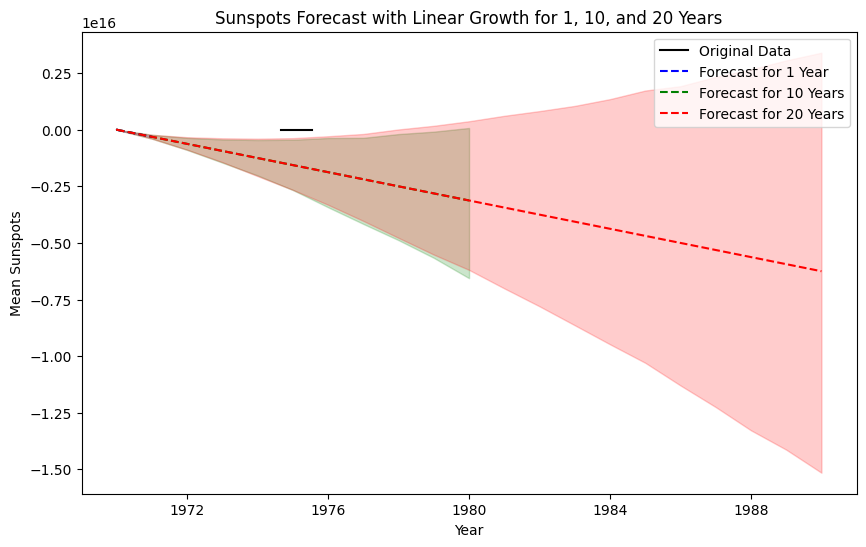

                               ds          yhat    yhat_lower    yhat_upper
318 1970-01-01 00:00:00.000002018  6.525337e+00  2.052609e+00  1.100094e+01
319 1970-01-01 00:00:00.000002019  6.515434e+00  2.078422e+00  1.095187e+01
320 1970-01-01 00:00:00.000002020  6.505531e+00  1.793429e+00  1.080110e+01
321 1970-01-01 00:00:00.000002021  6.495629e+00  1.619033e+00  1.121633e+01
322 1970-12-31 00:00:00.000002021 -3.114331e+14 -3.114331e+14 -3.114331e+14
                               ds          yhat    yhat_lower    yhat_upper
327 1975-12-31 00:00:00.000002021 -1.873732e+15 -3.424988e+15 -3.620590e+14
328 1976-12-31 00:00:00.000002021 -2.186876e+15 -4.162385e+15 -3.554238e+14
329 1977-12-31 00:00:00.000002021 -2.499165e+15 -4.879892e+15 -1.893549e+14
330 1978-12-31 00:00:00.000002021 -2.811453e+15 -5.659489e+15 -8.281327e+13
331 1979-12-31 00:00:00.000002021 -3.123742e+15 -6.556868e+15  7.912229e+13
                               ds          yhat    yhat_lower    yhat_upper
337 1985-12-

In [116]:
# Aggregate the data by year (Mean of sunspots per year)
data2['Year'] = data2['Date'].dt.year
data2_yearly = data2.groupby('Year').agg({'Std_Dev_Sunspots': 'mean'}).reset_index()

# Prepare the data for Prophet (renaming columns to 'ds' and 'y')
data_yearly_prophet = data2_yearly[['Year', 'Std_Dev_Sunspots']].rename(columns={'Year': 'ds', 'Std_Dev_Sunspots': 'y'})

# Initialize the Prophet model for linear growth
prophet_model_linear = Prophet(growth='linear')

# Fit the model
prophet_model_linear.fit(data_yearly_prophet)

# Function to predict sunspots for the given number of years into the future
def predict_sunspots_linear(periods):
    # Create future dataframe with specified periods (in years)
    future = prophet_model_linear.make_future_dataframe(periods=periods, freq='Y')

    # Forecast the future sunspots
    forecast = prophet_model_linear.predict(future)

    return forecast

# Predict for 1, 10, and 20 years
forecast_linear_1_year = predict_sunspots_linear(1)
forecast_linear_10_years = predict_sunspots_linear(10)
forecast_linear_20_years = predict_sunspots_linear(20)

# Plotting the predictions
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(data_yearly_prophet['ds'], data_yearly_prophet['y'], label="Original Data", color='black')

# Plot the forecast for 1, 10, and 20 years into the future
plt.plot(forecast_linear_1_year['ds'], forecast_linear_1_year['yhat'], label="Forecast for 1 Year", linestyle='--', color='blue')
plt.plot(forecast_linear_10_years['ds'], forecast_linear_10_years['yhat'], label="Forecast for 10 Years", linestyle='--', color='green')
plt.plot(forecast_linear_20_years['ds'], forecast_linear_20_years['yhat'], label="Forecast for 20 Years", linestyle='--', color='red')

# Add confidence intervals for the forecast
plt.fill_between(forecast_linear_1_year['ds'], forecast_linear_1_year['yhat_lower'], forecast_linear_1_year['yhat_upper'], color='blue', alpha=0.2)
plt.fill_between(forecast_linear_10_years['ds'], forecast_linear_10_years['yhat_lower'], forecast_linear_10_years['yhat_upper'], color='green', alpha=0.2)
plt.fill_between(forecast_linear_20_years['ds'], forecast_linear_20_years['yhat_lower'], forecast_linear_20_years['yhat_upper'], color='red', alpha=0.2)

# Adding labels and title
plt.title("Sunspots Forecast with Linear Growth for 1, 10, and 20 Years")
plt.xlabel("Year")
plt.ylabel("Mean Sunspots")
plt.legend()

# Show the plot
plt.show()

# Print the forecast results for 1, 10, and 20 years into the future
print(forecast_linear_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 1 year
print(forecast_linear_10_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 10 years
print(forecast_linear_20_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 20 years

**Flat Model Growth**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/__ztq3zr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8zlfe3ql/tl18x9ab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34463', 'data', 'file=/tmp/tmp8zlfe3ql/__ztq3zr.json', 'init=/tmp/tmp8zlfe3ql/tl18x9ab.json', 'output', 'file=/tmp/tmp8zlfe3ql/prophet_modeltx1g17nf/prophet_model-20241129182811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain

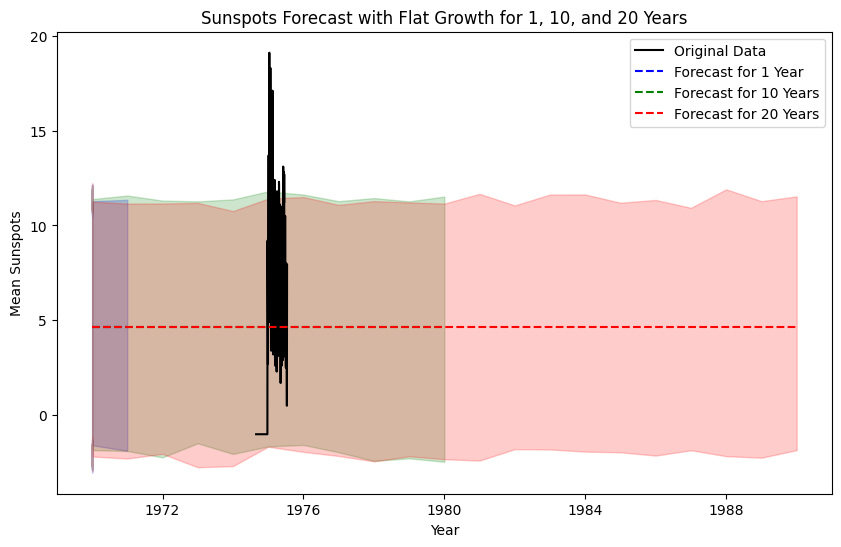

                               ds      yhat  yhat_lower  yhat_upper
318 1970-01-01 00:00:00.000002018  4.633507   -2.249917   11.350451
319 1970-01-01 00:00:00.000002019  4.633507   -2.134182   11.783587
320 1970-01-01 00:00:00.000002020  4.633507   -2.213678   11.593431
321 1970-01-01 00:00:00.000002021  4.633507   -1.581447   11.281479
322 1970-12-31 00:00:00.000002021  4.633507   -1.873880   11.347615
                               ds      yhat  yhat_lower  yhat_upper
327 1975-12-31 00:00:00.000002021  4.633507   -1.563770   11.627753
328 1976-12-31 00:00:00.000002021  4.633507   -1.949855   11.278835
329 1977-12-31 00:00:00.000002021  4.633507   -2.403642   11.442961
330 1978-12-31 00:00:00.000002021  4.633507   -2.271143   11.267538
331 1979-12-31 00:00:00.000002021  4.633507   -2.450981   11.522735
                               ds      yhat  yhat_lower  yhat_upper
337 1985-12-31 00:00:00.000002021  4.633507   -2.124256   11.344247
338 1986-12-31 00:00:00.000002021  4.633507   -1

In [115]:
# Aggregate the data by year (Mean of sunspots per year)
data2['Year'] = data2['Date'].dt.year
data2_yearly = data2.groupby('Year').agg({'Std_Dev_Sunspots': 'mean'}).reset_index()

# Prepare the data for Prophet (renaming columns to 'ds' and 'y')
data_yearly_prophet = data2_yearly[['Year', 'Std_Dev_Sunspots']].rename(columns={'Year': 'ds', 'Std_Dev_Sunspots': 'y'})

# Initialize the Prophet model for flat growth (no change)
prophet_model_flat = Prophet(growth='flat')

# Fit the model
prophet_model_flat.fit(data_yearly_prophet)

# Function to predict sunspots for the given number of years into the future
def predict_sunspots_flat(periods):
    # Create future dataframe with specified periods (in years)
    future = prophet_model_flat.make_future_dataframe(periods=periods, freq='Y')

    # Forecast the future sunspots
    forecast = prophet_model_flat.predict(future)

    return forecast

# Predict for 1, 10, and 20 years
forecast_flat_1_year = predict_sunspots_flat(1)
forecast_flat_10_years = predict_sunspots_flat(10)
forecast_flat_20_years = predict_sunspots_flat(20)

# Plotting the predictions
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(data_yearly_prophet['ds'], data_yearly_prophet['y'], label="Original Data", color='black')

# Plot the forecast for 1, 10, and 20 years into the future
plt.plot(forecast_flat_1_year['ds'], forecast_flat_1_year['yhat'], label="Forecast for 1 Year", linestyle='--', color='blue')
plt.plot(forecast_flat_10_years['ds'], forecast_flat_10_years['yhat'], label="Forecast for 10 Years", linestyle='--', color='green')
plt.plot(forecast_flat_20_years['ds'], forecast_flat_20_years['yhat'], label="Forecast for 20 Years", linestyle='--', color='red')

# Add confidence intervals for the forecast
plt.fill_between(forecast_flat_1_year['ds'], forecast_flat_1_year['yhat_lower'], forecast_flat_1_year['yhat_upper'], color='blue', alpha=0.2)
plt.fill_between(forecast_flat_10_years['ds'], forecast_flat_10_years['yhat_lower'], forecast_flat_10_years['yhat_upper'], color='green', alpha=0.2)
plt.fill_between(forecast_flat_20_years['ds'], forecast_flat_20_years['yhat_lower'], forecast_flat_20_years['yhat_upper'], color='red', alpha=0.2)

# Adding labels and title
plt.title("Sunspots Forecast with Flat Growth for 1, 10, and 20 Years")
plt.xlabel("Year")
plt.ylabel("Mean Sunspots")
plt.legend()

# Show the plot
plt.show()

# Print the forecast results for 1, 10, and 20 years into the future
print(forecast_flat_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 1 year
print(forecast_flat_10_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 10 years
print(forecast_flat_20_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Last few rows of forecast for 20 years